<a href="https://colab.research.google.com/github/thedevz43/materials-discovery_2/blob/main/GNSS_Error_Prediction_SIH_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torch torchvision torchaudio
!pip install numpy pandas matplotlib scikit-learn
!pip install scipy statsmodels
!pip install pytorch-lightning
!pip install properscoring


In [12]:
import os

folders = [
    "data/raw",
    "data/processed",
    "models",
    "results",
    "utils"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("Project folders created.")


Project folders created.


In [13]:
from google.colab import files

uploaded = files.upload()


Saving SIH_Data_PS-08.zip to SIH_Data_PS-08.zip


In [14]:
import os

os.listdir("/content")



['.config',
 'SIH_Data_PS-08.zip',
 'utils',
 'results',
 'data',
 'models',
 'sample_data']

In [15]:
!mv /content/*.csv /content/data/raw/


mv: cannot stat '/content/*.csv': No such file or directory


In [16]:
!unzip /content/*.zip -d /content/data/raw/


Archive:  /content/SIH_Data_PS-08.zip
  inflating: /content/data/raw/DATA_GEO_Test.csv  
  inflating: /content/data/raw/DATA_GEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Test.csv  
  inflating: /content/data/raw/DATA_MEO_Test2.csv  
  inflating: /content/data/raw/DATA_MEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Train2.csv  
  inflating: /content/data/raw/Note.pdf  
  inflating: /content/data/raw/SIH_Data_Discription.pdf  
  inflating: /content/data/raw/SW_ReferenceData.xlsx  


In [17]:
!unzip "/content/*.zip" -d /content/data/raw/


Archive:  /content/SIH_Data_PS-08.zip
replace /content/data/raw/DATA_GEO_Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [18]:
import os

csv_files = [f for f in os.listdir("/content/data/raw") if f.endswith(".csv")]
csv_files


['DATA_GEO_Test.csv',
 'DATA_MEO_Test.csv',
 'DATA_MEO_Train.csv',
 'DATA_GEO_Train.csv',
 'DATA_MEO_Train2.csv',
 'DATA_MEO_Test2.csv']

In [19]:
import pandas as pd

geo_train = pd.read_csv("/content/data/raw/DATA_GEO_Train.csv")

print("Shape:", geo_train.shape)
geo_train.head()


Shape: (142, 5)


utc_time  x_error (m)  y_error (m)  z_error (m)  satclockerror (m)
0   9/1/2025 6:00     5.333443     4.530495    -2.600099           1.280427
1   9/1/2025 8:00     0.222901     0.177056    -0.008267          -3.609894
2  9/1/2025 10:00     0.542796     1.124622     6.286751          -0.419839
3  9/1/2025 12:00     0.164464     0.013855     0.007338          -0.318279
4  9/1/2025 14:00    -0.838448    -0.667825     0.676121           1.428765

In [20]:
geo_train.columns.tolist()


['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']

In [21]:
geo_train.iloc[:5, :3]   # show first few columns


utc_time  x_error (m)  y_error (m)
0   9/1/2025 6:00     5.333443     4.530495
1   9/1/2025 8:00     0.222901     0.177056
2  9/1/2025 10:00     0.542796     1.124622
3  9/1/2025 12:00     0.164464     0.013855
4  9/1/2025 14:00    -0.838448    -0.667825

In [22]:
geo_train.head()

geo_train.columns.tolist()

['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']

In [23]:
geo_train["utc_time"] = pd.to_datetime(geo_train["utc_time"])
geo_train = geo_train.sort_values("utc_time")

geo_train.head()


utc_time  x_error (m)  y_error (m)  z_error (m)  \
0 2025-09-01 06:00:00     5.333443     4.530495    -2.600099   
1 2025-09-01 08:00:00     0.222901     0.177056    -0.008267   
2 2025-09-01 10:00:00     0.542796     1.124622     6.286751   
3 2025-09-01 12:00:00     0.164464     0.013855     0.007338   
4 2025-09-01 14:00:00    -0.838448    -0.667825     0.676121   

   satclockerror (m)  
0           1.280427  
1          -3.609894  
2          -0.419839  
3          -0.318279  
4           1.428765

In [24]:
geo_train["dt"] = geo_train["utc_time"].diff()
geo_train["dt"].value_counts().head()


dt
0 days 02:00:00    66
0 days 00:15:00    45
0 days 00:16:00     9
0 days 00:14:00     8
0 days 00:20:00     3
Name: count, dtype: int64

In [25]:
geo_train = geo_train.rename(columns={
    "utc_time": "timestamp",
    "x_error (m)": "x_err",
    "y_error (m)": "y_err",
    "z_error (m)": "z_err",
    "satclockerror (m)": "clock_err"
})

geo_train.head()


timestamp     x_err     y_err     z_err  clock_err              dt
0 2025-09-01 06:00:00  5.333443  4.530495 -2.600099   1.280427             NaT
1 2025-09-01 08:00:00  0.222901  0.177056 -0.008267  -3.609894 0 days 02:00:00
2 2025-09-01 10:00:00  0.542796  1.124622  6.286751  -0.419839 0 days 02:00:00
3 2025-09-01 12:00:00  0.164464  0.013855  0.007338  -0.318279 0 days 02:00:00
4 2025-09-01 14:00:00 -0.838448 -0.667825  0.676121   1.428765 0 days 02:00:00

In [26]:
geo_train.isna().sum()


timestamp    0
x_err        0
y_err        0
z_err        0
clock_err    0
dt           1
dtype: int64

In [27]:
import numpy as np

geo_train["minute_of_day"] = (
    geo_train["timestamp"].dt.hour * 60 +
    geo_train["timestamp"].dt.minute
)

geo_train["sin_time"] = np.sin(2 * np.pi * geo_train["minute_of_day"] / 1440)
geo_train["cos_time"] = np.cos(2 * np.pi * geo_train["minute_of_day"] / 1440)

geo_train.head()


timestamp     x_err     y_err     z_err  clock_err  \
0 2025-09-01 06:00:00  5.333443  4.530495 -2.600099   1.280427   
1 2025-09-01 08:00:00  0.222901  0.177056 -0.008267  -3.609894   
2 2025-09-01 10:00:00  0.542796  1.124622  6.286751  -0.419839   
3 2025-09-01 12:00:00  0.164464  0.013855  0.007338  -0.318279   
4 2025-09-01 14:00:00 -0.838448 -0.667825  0.676121   1.428765   

               dt  minute_of_day      sin_time      cos_time  
0             NaT            360  1.000000e+00  6.123234e-17  
1 0 days 02:00:00            480  8.660254e-01 -5.000000e-01  
2 0 days 02:00:00            600  5.000000e-01 -8.660254e-01  
3 0 days 02:00:00            720  1.224647e-16 -1.000000e+00  
4 0 days 02:00:00            840 -5.000000e-01 -8.660254e-01

In [28]:
INPUT_STEPS = 96    # past 24 hours
OUTPUT_STEPS = 96   # next 24 hours

FEATURE_COLS = [
    "x_err", "y_err", "z_err", "clock_err",
    "sin_time", "cos_time"
]

TARGET_COLS = [
    "x_err", "y_err", "z_err", "clock_err"
]


In [29]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    values = df[FEATURE_COLS].values
    targets = df[TARGET_COLS].values

    for i in range(len(df) - input_steps - output_steps):
        X.append(values[i:i+input_steps])
        Y.append(targets[i+input_steps:i+input_steps+output_steps])

    return np.array(X), np.array(Y)

X_geo, Y_geo = create_windows(geo_train, INPUT_STEPS, OUTPUT_STEPS)

print("X_geo shape:", X_geo.shape)
print("Y_geo shape:", Y_geo.shape)


X_geo shape: (0,)
Y_geo shape: (0,)


In [30]:
len(geo_train)


142

In [31]:
geo_train["timestamp"].min(), geo_train["timestamp"].max()


(Timestamp('2025-09-01 06:00:00'), Timestamp('2025-09-07 23:41:00'))

In [32]:
import pandas as pd
import numpy as np

# Load GEO training data
geo_train = pd.read_csv("/content/data/raw/DATA_GEO_Train.csv")

# Convert utc_time to timestamp
geo_train["timestamp"] = pd.to_datetime(geo_train["utc_time"])

# Sort by time (VERY IMPORTANT)
geo_train = geo_train.sort_values("timestamp").reset_index(drop=True)

# Drop original utc_time column
geo_train = geo_train.drop(columns=["utc_time"])

print("Rows:", len(geo_train))
geo_train.head()


Rows: 142


x_error (m)  y_error (m)  z_error (m)  satclockerror (m)  \
0     5.333443     4.530495    -2.600099           1.280427   
1     0.222901     0.177056    -0.008267          -3.609894   
2     0.542796     1.124622     6.286751          -0.419839   
3     0.164464     0.013855     0.007338          -0.318279   
4    -0.838448    -0.667825     0.676121           1.428765   

            timestamp  
0 2025-09-01 06:00:00  
1 2025-09-01 08:00:00  
2 2025-09-01 10:00:00  
3 2025-09-01 12:00:00  
4 2025-09-01 14:00:00

In [33]:
# Input features
FEATURE_COLS = [
    "x_error (m)",
    "y_error (m)",
    "z_error (m)",
    "satclockerror (m)"
]

# Output targets (same as features for forecasting)
TARGET_COLS = FEATURE_COLS

# Sanity check
geo_train[FEATURE_COLS].describe()


x_error (m)  y_error (m)  z_error (m)  satclockerror (m)
count   142.000000   142.000000   142.000000         142.000000
mean      0.516036     0.527799     0.443816           0.122377
std       5.040085     8.703102     6.586577           3.809101
min     -19.786400   -41.095775   -31.553938         -23.436187
25%      -1.099929    -0.852365    -1.462396          -0.514385
50%       0.113727     0.101100     0.024722           0.105532
75%       1.623782     1.714523     2.077592           1.158652
max      23.492488    40.295118    39.227673          23.323345

In [34]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

geo_train[FEATURE_COLS] = feature_scaler.fit_transform(
    geo_train[FEATURE_COLS]
)

geo_train[TARGET_COLS] = target_scaler.fit_transform(
    geo_train[TARGET_COLS]
)


In [35]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []

    data = df[FEATURE_COLS].values

    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])

    return np.array(X), np.array(Y)


In [36]:
INPUT_STEPS = 24   # past samples
OUTPUT_STEPS = 12  # future samples

X_geo, Y_geo = create_windows(geo_train, INPUT_STEPS, OUTPUT_STEPS)

print("X_geo shape:", X_geo.shape)
print("Y_geo shape:", Y_geo.shape)


X_geo shape: (107, 24, 4)
Y_geo shape: (107, 12, 4)


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X_geo,
    Y_geo,
    test_size=0.2,
    random_state=42
)

print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Train samples: 85
Validation samples: 22


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset   = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [39]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, self.output_steps, self.output_dim)

model = LSTMForecaster(
    input_dim=4,
    hidden_dim=64,
    output_dim=4,
    output_steps=12
)

model


LSTMForecaster(
  (lstm): LSTM(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=48, bias=True)
)

In [40]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, Yb).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: 1.1947 | Val Loss: 0.8133
Epoch 02 | Train Loss: 1.2673 | Val Loss: 0.8148
Epoch 03 | Train Loss: 1.2803 | Val Loss: 0.8164
Epoch 04 | Train Loss: 1.2380 | Val Loss: 0.8185
Epoch 05 | Train Loss: 1.2408 | Val Loss: 0.8205
Epoch 06 | Train Loss: 1.1438 | Val Loss: 0.8223
Epoch 07 | Train Loss: 1.3179 | Val Loss: 0.8246
Epoch 08 | Train Loss: 1.2025 | Val Loss: 0.8274
Epoch 09 | Train Loss: 1.1466 | Val Loss: 0.8301
Epoch 10 | Train Loss: 1.1800 | Val Loss: 0.8314
Epoch 11 | Train Loss: 1.2701 | Val Loss: 0.8329
Epoch 12 | Train Loss: 1.1781 | Val Loss: 0.8354
Epoch 13 | Train Loss: 1.1680 | Val Loss: 0.8386
Epoch 14 | Train Loss: 1.1400 | Val Loss: 0.8376
Epoch 15 | Train Loss: 1.3234 | Val Loss: 0.8391
Epoch 16 | Train Loss: 1.3570 | Val Loss: 0.8373
Epoch 17 | Train Loss: 1.1906 | Val Loss: 0.8398
Epoch 18 | Train Loss: 1.2664 | Val Loss: 0.8402
Epoch 19 | Train Loss: 1.2368 | Val Loss: 0.8399
Epoch 20 | Train Loss: 1.3039 | Val Loss: 0.8501
Epoch 21 | Train Los

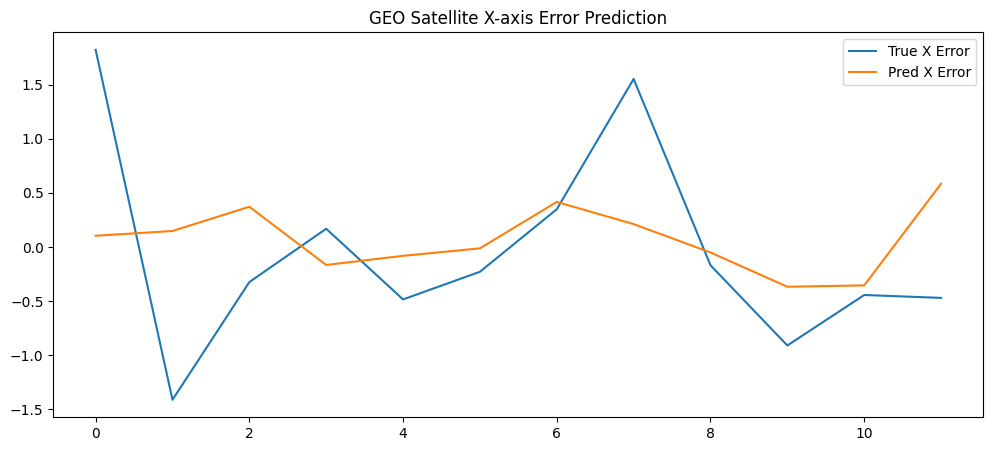

In [41]:
import matplotlib.pyplot as plt

model.eval()
X_sample, Y_true = val_dataset[0]
X_sample = X_sample.unsqueeze(0).to(device)

with torch.no_grad():
    Y_pred = model(X_sample).cpu().numpy()

Y_true = Y_true.numpy()

plt.figure(figsize=(12,5))
plt.plot(Y_true[:,0], label="True X Error")
plt.plot(Y_pred[0,:,0], label="Pred X Error")
plt.legend()
plt.title("GEO Satellite X-axis Error Prediction")
plt.show()


In [42]:
import pandas as pd
import numpy as np

# Load GEO Train + Test
geo_train = pd.read_csv("/content/data/raw/DATA_GEO_Train.csv")
geo_test  = pd.read_csv("/content/data/raw/DATA_GEO_Test.csv")

# Convert utc_time to datetime
for df in [geo_train, geo_test]:
    df["timestamp"] = pd.to_datetime(df["utc_time"])
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)
    df.sort_values("timestamp", inplace=True)

# Merge datasets
geo_all = pd.concat([geo_train, geo_test]).sort_values("timestamp").reset_index(drop=True)

print("Merged GEO dataset shape:", geo_all.shape)
geo_all.head()


Merged GEO dataset shape: (211, 6)


utc_time     x_err     y_err     z_err  clock_err           timestamp
0   9/1/2025 6:00  5.333443  4.530495 -2.600099   1.280427 2025-09-01 06:00:00
1   9/1/2025 8:00  0.222901  0.177056 -0.008267  -3.609894 2025-09-01 08:00:00
2  9/1/2025 10:00  0.542796  1.124622  6.286751  -0.419839 2025-09-01 10:00:00
3  9/1/2025 12:00  0.164464  0.013855  0.007338  -0.318279 2025-09-01 12:00:00
4  9/1/2025 14:00 -0.838448 -0.667825  0.676121   1.428765 2025-09-01 14:00:00

In [43]:
from sklearn.preprocessing import StandardScaler

FEATURE_COLS = ["x_err", "y_err", "z_err", "clock_err"]
TARGET_COLS  = FEATURE_COLS

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

geo_all[FEATURE_COLS] = feature_scaler.fit_transform(geo_all[FEATURE_COLS])
geo_all[TARGET_COLS]  = target_scaler.fit_transform(geo_all[TARGET_COLS])


In [44]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    data = df[FEATURE_COLS].values
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

INPUT_STEPS = 24   # past 6 hours
OUTPUT_STEPS = 12  # next 3 hours

X_geo, Y_geo = create_windows(geo_all, INPUT_STEPS, OUTPUT_STEPS)
print("X_geo shape:", X_geo.shape)
print("Y_geo shape:", Y_geo.shape)


X_geo shape: (176, 24, 4)
Y_geo shape: (176, 12, 4)


from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

X_train, X_val, Y_train, Y_val = train_test_split(
    X_geo, Y_geo, test_size=0.2, random_state=42
)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset   = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


In [45]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, self.output_steps, self.output_dim)

model = LSTMForecaster(
    input_dim=4,
    hidden_dim=64,
    output_dim=4,
    output_steps=OUTPUT_STEPS,
    dropout=0.2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTMForecaster(
  (lstm): LSTM(4, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=48, bias=True)
)

In [46]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, Yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: 1.1544 | Val Loss: 0.8144
Epoch 02 | Train Loss: 1.2941 | Val Loss: 0.8169
Epoch 03 | Train Loss: 1.1322 | Val Loss: 0.8189
Epoch 04 | Train Loss: 1.1647 | Val Loss: 0.8208
Epoch 05 | Train Loss: 1.2530 | Val Loss: 0.8225
Epoch 06 | Train Loss: 1.1685 | Val Loss: 0.8242
Epoch 07 | Train Loss: 1.2624 | Val Loss: 0.8251
Epoch 08 | Train Loss: 1.1618 | Val Loss: 0.8285
Epoch 09 | Train Loss: 1.3730 | Val Loss: 0.8310
Epoch 10 | Train Loss: 1.2250 | Val Loss: 0.8373
Epoch 11 | Train Loss: 1.3007 | Val Loss: 0.8368
Epoch 12 | Train Loss: 1.2324 | Val Loss: 0.8358
Epoch 13 | Train Loss: 1.1549 | Val Loss: 0.8333
Epoch 14 | Train Loss: 1.2200 | Val Loss: 0.8339
Epoch 15 | Train Loss: 1.3619 | Val Loss: 0.8336
Epoch 16 | Train Loss: 1.1522 | Val Loss: 0.8359
Epoch 17 | Train Loss: 1.1007 | Val Loss: 0.8416
Epoch 18 | Train Loss: 1.2184 | Val Loss: 0.8468
Epoch 19 | Train Loss: 1.1895 | Val Loss: 0.8476
Epoch 20 | Train Loss: 1.2549 | Val Loss: 0.8514
Epoch 21 | Train Los

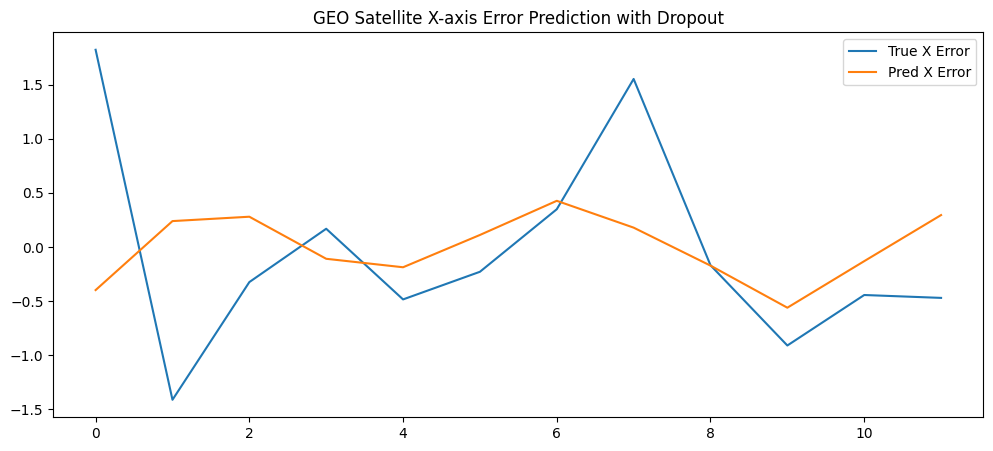

In [47]:
import matplotlib.pyplot as plt

model.eval()
X_sample, Y_true = val_dataset[0]
X_sample = X_sample.unsqueeze(0).to(device)

with torch.no_grad():
    Y_pred = model(X_sample).cpu().numpy()

Y_true = Y_true.numpy()

plt.figure(figsize=(12,5))
plt.plot(Y_true[:,0], label="True X Error")
plt.plot(Y_pred[0,:,0], label="Pred X Error")
plt.legend()
plt.title("GEO Satellite X-axis Error Prediction with Dropout")
plt.show()


In [48]:
import pandas as pd
import numpy as np

# Load MEO Train + Test
meo_train = pd.read_csv("/content/data/raw/DATA_MEO_Train.csv")
meo_train2 = pd.read_csv("/content/data/raw/DATA_MEO_Train2.csv")
meo_test  = pd.read_csv("/content/data/raw/DATA_MEO_Test.csv")
meo_test2 = pd.read_csv("/content/data/raw/DATA_MEO_Test2.csv")

# Convert utc_time to datetime & rename columns
for df in [meo_train, meo_train2, meo_test, meo_test2]:
    df["timestamp"] = pd.to_datetime(df["utc_time"])
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)
    df.sort_values("timestamp", inplace=True)

# Merge all MEO datasets
meo_all = pd.concat([meo_train, meo_train2, meo_test, meo_test2]).sort_values("timestamp").reset_index(drop=True)

print("Merged MEO dataset shape:", meo_all.shape)
meo_all.head()


Merged MEO dataset shape: (375, 7)


utc_time     x_err  y_error  (m)     z_err  clock_err  \
0  9/1/2025 14:00 -0.765883      0.671544  0.434251  -0.183989   
1  9/1/2025 14:00 -0.765883      0.671544  0.434251  -0.183989   
2  9/1/2025 15:00 -0.568186      0.392191  0.637844  -0.159422   
3  9/1/2025 15:00 -0.568186      0.392191  0.637844  -0.159422   
4  9/1/2025 16:00 -0.535862      0.174319  0.723323   0.035761   

            timestamp  y_err  
0 2025-09-01 14:00:00    NaN  
1 2025-09-01 14:00:00    NaN  
2 2025-09-01 15:00:00    NaN  
3 2025-09-01 15:00:00    NaN  
4 2025-09-01 16:00:00    NaN

from sklearn.preprocessing import StandardScaler

FEATURE_COLS = ["x_err", "y_err", "z_err", "clock_err"]
TARGET_COLS  = FEATURE_COLS

feature_scaler_meo = StandardScaler()
target_scaler_meo = StandardScaler()

meo_all[FEATURE_COLS] = feature_scaler_meo.fit_transform(meo_all[FEATURE_COLS])
meo_all[TARGET_COLS]  = target_scaler_meo.fit_transform(meo_all[TARGET_COLS])


In [49]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    data = df[FEATURE_COLS].values
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

INPUT_STEPS = 48   # past 12 hours (MEO has denser data)
OUTPUT_STEPS = 24  # next 6 hours

X_meo, Y_meo = create_windows(meo_all, INPUT_STEPS, OUTPUT_STEPS)
print("X_meo shape:", X_meo.shape)
print("Y_meo shape:", Y_meo.shape)


X_meo shape: (304, 48, 4)
Y_meo shape: (304, 24, 4)


In [50]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

X_train, X_val, Y_train, Y_val = train_test_split(
    X_meo, Y_meo, test_size=0.2, random_state=42
)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset   = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Train samples: 243
Validation samples: 61


In [51]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, self.output_steps, self.output_dim)

model = LSTMForecaster(
    input_dim=4,
    hidden_dim=64,
    output_dim=4,
    output_steps=OUTPUT_STEPS,
    dropout=0.2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTMForecaster(
  (lstm): LSTM(4, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=96, bias=True)
)

In [52]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50  # MEO dataset is bigger, so more epochs

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, Yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: nan | Val Loss: nan
Epoch 02 | Train Loss: nan | Val Loss: nan
Epoch 03 | Train Loss: nan | Val Loss: nan
Epoch 04 | Train Loss: nan | Val Loss: nan
Epoch 05 | Train Loss: nan | Val Loss: nan
Epoch 06 | Train Loss: nan | Val Loss: nan
Epoch 07 | Train Loss: nan | Val Loss: nan
Epoch 08 | Train Loss: nan | Val Loss: nan
Epoch 09 | Train Loss: nan | Val Loss: nan
Epoch 10 | Train Loss: nan | Val Loss: nan
Epoch 11 | Train Loss: nan | Val Loss: nan
Epoch 12 | Train Loss: nan | Val Loss: nan
Epoch 13 | Train Loss: nan | Val Loss: nan
Epoch 14 | Train Loss: nan | Val Loss: nan
Epoch 15 | Train Loss: nan | Val Loss: nan
Epoch 16 | Train Loss: nan | Val Loss: nan
Epoch 17 | Train Loss: nan | Val Loss: nan
Epoch 18 | Train Loss: nan | Val Loss: nan
Epoch 19 | Train Loss: nan | Val Loss: nan
Epoch 20 | Train Loss: nan | Val Loss: nan
Epoch 21 | Train Loss: nan | Val Loss: nan
Epoch 22 | Train Loss: nan | Val Loss: nan
Epoch 23 | Train Loss: nan | Val Loss: nan
Epoch 24 | 

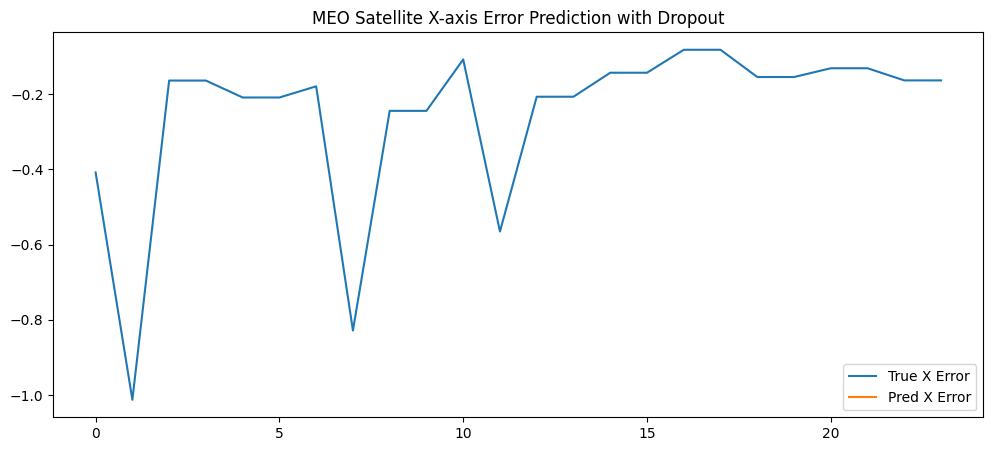

In [53]:
import matplotlib.pyplot as plt

model.eval()
X_sample, Y_true = val_dataset[0]
X_sample = X_sample.unsqueeze(0).to(device)

with torch.no_grad():
    Y_pred = model(X_sample).cpu().numpy()

Y_true = Y_true.numpy()

plt.figure(figsize=(12,5))
plt.plot(Y_true[:,0], label="True X Error")
plt.plot(Y_pred[0,:,0], label="Pred X Error")
plt.legend()
plt.title("MEO Satellite X-axis Error Prediction with Dropout")
plt.show()


In [54]:
import pandas as pd
import numpy as np

# Load MEO Train + Test
meo_train = pd.read_csv("/content/data/raw/DATA_MEO_Train.csv")
meo_train2 = pd.read_csv("/content/data/raw/DATA_MEO_Train2.csv")
meo_test  = pd.read_csv("/content/data/raw/DATA_MEO_Test.csv")
meo_test2 = pd.read_csv("/content/data/raw/DATA_MEO_Test2.csv")

# Convert utc_time to datetime & rename columns
for df in [meo_train, meo_train2, meo_test, meo_test2]:
    df["timestamp"] = pd.to_datetime(df["utc_time"])
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)
    df.sort_values("timestamp", inplace=True)

# Merge all MEO datasets
meo_all = pd.concat([meo_train, meo_train2, meo_test, meo_test2]).sort_values("timestamp").reset_index(drop=True)

# Check for NaNs
print("NaNs in dataset:", meo_all.isna().sum().sum())

# Drop NaNs if any
meo_all = meo_all.dropna().reset_index(drop=True)

print("Merged MEO dataset shape (after NaN removal):", meo_all.shape)
meo_all.head()


NaNs in dataset: 375
Merged MEO dataset shape (after NaN removal): (0, 7)


Empty DataFrame
Columns: [utc_time, x_err, y_error  (m), z_err, clock_err, timestamp, y_err]
Index: []

In [55]:
# Check actual column names in all MEO CSVs
for file in ["/content/data/raw/DATA_MEO_Train.csv",
             "/content/data/raw/DATA_MEO_Train2.csv",
             "/content/data/raw/DATA_MEO_Test.csv",
             "/content/data/raw/DATA_MEO_Test2.csv"]:
    df = pd.read_csv(file, nrows=5)
    print(f"Columns in {file}:")
    print(df.columns.tolist())
    print("-"*50)


Columns in /content/data/raw/DATA_MEO_Train.csv:
['utc_time', 'x_error (m)', 'y_error  (m)', 'z_error (m)', 'satclockerror (m)']
--------------------------------------------------
Columns in /content/data/raw/DATA_MEO_Train2.csv:
['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']
--------------------------------------------------
Columns in /content/data/raw/DATA_MEO_Test.csv:
['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']
--------------------------------------------------
Columns in /content/data/raw/DATA_MEO_Test2.csv:
['utc_time', 'x_error (m)', 'y_error (m)', 'z_error (m)', 'satclockerror (m)']
--------------------------------------------------


In [56]:
import pandas as pd

# Load all MEO files
files = [
    "/content/data/raw/DATA_MEO_Train.csv",
    "/content/data/raw/DATA_MEO_Train2.csv",
    "/content/data/raw/DATA_MEO_Test.csv",
    "/content/data/raw/DATA_MEO_Test2.csv"
]

dfs = []
for f in files:
    df = pd.read_csv(f)
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Rename to consistent names, handling both single and double space variations
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "y_error  (m)": "y_err", # Added to handle the extra space in DATA_MEO_Train.csv
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)

    # Keep only needed columns
    df = df[["utc_time", "x_err", "y_err", "z_err", "clock_err"]]

    dfs.append(df)

# Merge all
meo_all = pd.concat(dfs).sort_values("utc_time").reset_index(drop=True)

# Convert utc_time to datetime after merging for consistent sorting
meo_all["timestamp"] = pd.to_datetime(meo_all["utc_time"])
meo_all.drop(columns=["utc_time"], inplace=True)

# Check for NaNs
print("Merged MEO shape:", meo_all.shape)
print("NaNs in dataset:\n", meo_all.isna().sum())

Merged MEO shape: (375, 5)
NaNs in dataset:
 x_err        0
y_err        0
z_err        0
clock_err    0
timestamp    0
dtype: int64


In [57]:
import pandas as pd

# List of files
files = [
    "/content/data/raw/DATA_MEO_Train.csv",
    "/content/data/raw/DATA_MEO_Train2.csv",
    "/content/data/raw/DATA_MEO_Test.csv",
    "/content/data/raw/DATA_MEO_Test2.csv"
]

dfs = []
for f in files:
    df = pd.read_csv(f)

    # Strip spaces from column names
    df.columns = df.columns.str.replace(r"\s+", " ", regex=True)  # replace multiple spaces with single
    df.columns = df.columns.str.strip()  # remove leading/trailing spaces

    # Rename consistently
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)

    # Keep only required columns
    df = df[["utc_time", "x_err", "y_err", "z_err", "clock_err"]]

    dfs.append(df)

# Merge all
meo_all = pd.concat(dfs).sort_values("utc_time").reset_index(drop=True)

# Check
print("Merged MEO shape:", meo_all.shape)
print("NaNs in dataset:", meo_all.isna().sum())


Merged MEO shape: (375, 5)
NaNs in dataset: utc_time     0
x_err        0
y_err        0
z_err        0
clock_err    0
dtype: int64


In [58]:
import pandas as pd
import numpy as np

# meo_all is already cleaned from previous step
meo_all["timestamp"] = pd.to_datetime(meo_all["utc_time"])
meo_all.sort_values("timestamp", inplace=True)
meo_all.reset_index(drop=True, inplace=True)

# Features and targets
FEATURE_COLS = ["x_err","y_err","z_err","clock_err"]
TARGET_COLS  = FEATURE_COLS


In [59]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler  = StandardScaler()

meo_all[FEATURE_COLS] = feature_scaler.fit_transform(meo_all[FEATURE_COLS])
meo_all[TARGET_COLS]  = target_scaler.fit_transform(meo_all[TARGET_COLS])

In [60]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    data = df[FEATURE_COLS].values
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

INPUT_STEPS = 48   # past 12 hours
OUTPUT_STEPS = 24  # next 6 hours

X_meo, Y_meo = create_windows(meo_all, INPUT_STEPS, OUTPUT_STEPS)
print("X_meo shape:", X_meo.shape)
print("Y_meo shape:", Y_meo.shape)


X_meo shape: (304, 48, 4)
Y_meo shape: (304, 24, 4)


In [61]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

X_train, X_val, Y_train, Y_val = train_test_split(
    X_meo, Y_meo, test_size=0.2, random_state=42
)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset   = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Train samples: 243
Validation samples: 61


In [62]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,
                            num_layers=num_layers, dropout=dropout)
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, self.output_steps, self.output_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(input_dim=4, hidden_dim=32, output_dim=4,
                        output_steps=OUTPUT_STEPS, num_layers=2, dropout=0.2)
model.to(device)
model


LSTMForecaster(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=96, bias=True)
)

In [63]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, Yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, Yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: 1.0397 | Val Loss: 0.8991
Epoch 02 | Train Loss: 1.0829 | Val Loss: 0.8958
Epoch 03 | Train Loss: 1.0448 | Val Loss: 0.8928
Epoch 04 | Train Loss: 1.0692 | Val Loss: 0.8897
Epoch 05 | Train Loss: 1.0926 | Val Loss: 0.8857
Epoch 06 | Train Loss: 1.0274 | Val Loss: 0.8817
Epoch 07 | Train Loss: 1.0534 | Val Loss: 0.8772
Epoch 08 | Train Loss: 1.0195 | Val Loss: 0.8739
Epoch 09 | Train Loss: 1.0023 | Val Loss: 0.8706
Epoch 10 | Train Loss: 1.0779 | Val Loss: 0.8668
Epoch 11 | Train Loss: 0.9768 | Val Loss: 0.8640
Epoch 12 | Train Loss: 0.9849 | Val Loss: 0.8584
Epoch 13 | Train Loss: 0.9668 | Val Loss: 0.8508
Epoch 14 | Train Loss: 1.0296 | Val Loss: 0.8389
Epoch 15 | Train Loss: 0.9543 | Val Loss: 0.8302
Epoch 16 | Train Loss: 0.9426 | Val Loss: 0.8261
Epoch 17 | Train Loss: 0.9401 | Val Loss: 0.8211
Epoch 18 | Train Loss: 0.9406 | Val Loss: 0.8159
Epoch 19 | Train Loss: 0.9384 | Val Loss: 0.8119
Epoch 20 | Train Loss: 0.9148 | Val Loss: 0.8073
Epoch 21 | Train Los

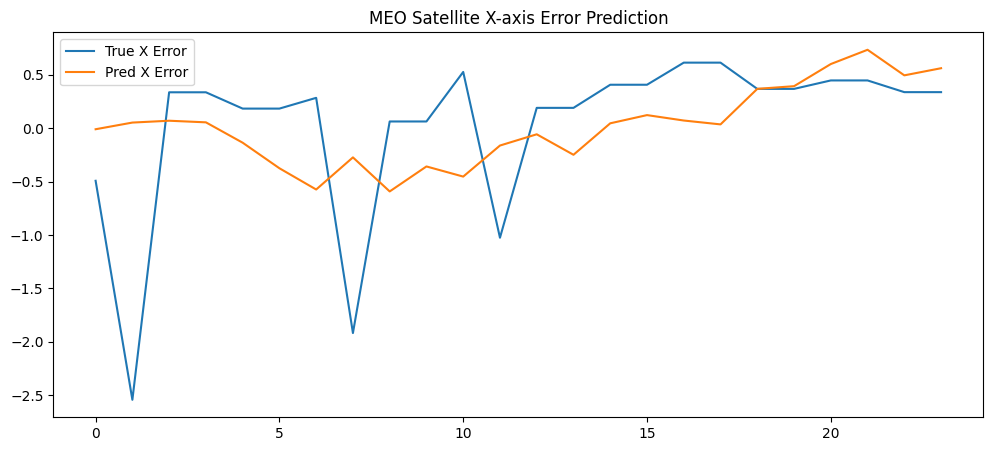

In [64]:
import matplotlib.pyplot as plt

model.eval()
X_sample, Y_true = val_dataset[0]
X_sample = X_sample.unsqueeze(0).to(device)

with torch.no_grad():
    Y_pred = model(X_sample).cpu().numpy()

Y_true = Y_true.numpy()

plt.figure(figsize=(12,5))
plt.plot(Y_true[:,0], label="True X Error")
plt.plot(Y_pred[0,:,0], label="Pred X Error")
plt.legend()
plt.title("MEO Satellite X-axis Error Prediction")
plt.show()


In [65]:
# Assuming geo_all and meo_all are already cleaned
# geo_all columns: ['utc_time','x_err','y_err','z_err','clock_err']
# meo_all columns: ['utc_time','x_err','y_err','z_err','clock_err']

# Convert timestamps
for df in [geo_all, meo_all]:
    df["timestamp"] = pd.to_datetime(df["utc_time"])
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)

FEATURE_COLS = ["x_err","y_err","z_err","clock_err"]
TARGET_COLS  = FEATURE_COLS


In [66]:
from sklearn.preprocessing import StandardScaler

# GEO scalers
geo_feature_scaler = StandardScaler()
geo_target_scaler  = StandardScaler()
geo_all[FEATURE_COLS] = geo_feature_scaler.fit_transform(geo_all[FEATURE_COLS])
geo_all[TARGET_COLS]  = geo_target_scaler.fit_transform(geo_all[TARGET_COLS])

# MEO scalers
meo_feature_scaler = StandardScaler()
meo_target_scaler  = StandardScaler()
meo_all[FEATURE_COLS] = meo_feature_scaler.fit_transform(meo_all[FEATURE_COLS])
meo_all[TARGET_COLS]  = meo_target_scaler.fit_transform(meo_all[TARGET_COLS])

In [67]:
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    data = df[FEATURE_COLS].values
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

INPUT_STEPS = 48   # past 12 hours
OUTPUT_STEPS = 24  # next 6 hours


In [68]:
X_geo, Y_geo = create_windows(geo_all, INPUT_STEPS, OUTPUT_STEPS)
X_meo, Y_meo = create_windows(meo_all, INPUT_STEPS, OUTPUT_STEPS)

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# GEO split
X_geo_train, X_geo_val, Y_geo_train, Y_geo_val = train_test_split(X_geo, Y_geo, test_size=0.2, random_state=42)
geo_train_dataset = TimeSeriesDataset(X_geo_train, Y_geo_train)
geo_val_dataset   = TimeSeriesDataset(X_geo_val, Y_geo_val)
geo_train_loader  = DataLoader(geo_train_dataset, batch_size=16, shuffle=True)
geo_val_loader    = DataLoader(geo_val_dataset, batch_size=16, shuffle=False)

# MEO split
X_meo_train, X_meo_val, Y_meo_train, Y_meo_val = train_test_split(X_meo, Y_meo, test_size=0.2, random_state=42)
meo_train_dataset = TimeSeriesDataset(X_meo_train, Y_meo_train)
meo_val_dataset   = TimeSeriesDataset(X_meo_val, Y_meo_val)
meo_train_loader  = DataLoader(meo_train_dataset, batch_size=16, shuffle=True)
meo_val_loader    = DataLoader(meo_val_dataset, batch_size=16, shuffle=False)

print("GEO Train samples:", len(geo_train_dataset))
print("MEO Train samples:", len(meo_train_dataset))


GEO Train samples: 112
MEO Train samples: 243


import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,
                            num_layers=num_layers, dropout=dropout)
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.view(-1, self.output_steps, self.output_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Separate models for GEO and MEO
geo_model = LSTMForecaster(4, 32, 4, OUTPUT_STEPS, num_layers=2, dropout=0.2).to(device)
meo_model = LSTMForecaster(4, 32, 4, OUTPUT_STEPS, num_layers=2, dropout=0.2).to(device)


In [69]:
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=50, lr=0.0005):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                preds = model(Xb)
                val_loss += criterion(preds, Yb).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [70]:
print("Training GEO model...")
train_model(geo_model, geo_train_loader, geo_val_loader, epochs=50)

print("Training MEO model...")
train_model(meo_model, meo_train_loader, meo_val_loader, epochs=50)



Training GEO model...
Epoch 01 | Train Loss: 1.3762 | Val Loss: 1.3926
Epoch 02 | Train Loss: 1.3743 | Val Loss: 1.3930
Epoch 03 | Train Loss: 1.3732 | Val Loss: 1.3937
Epoch 04 | Train Loss: 1.3722 | Val Loss: 1.3945
Epoch 05 | Train Loss: 1.3710 | Val Loss: 1.3954
Epoch 06 | Train Loss: 1.3705 | Val Loss: 1.3969
Epoch 07 | Train Loss: 1.3695 | Val Loss: 1.3984
Epoch 08 | Train Loss: 1.3687 | Val Loss: 1.3994
Epoch 09 | Train Loss: 1.3681 | Val Loss: 1.4013
Epoch 10 | Train Loss: 1.3673 | Val Loss: 1.4027
Epoch 11 | Train Loss: 1.3668 | Val Loss: 1.4044
Epoch 12 | Train Loss: 1.3669 | Val Loss: 1.4059
Epoch 13 | Train Loss: 1.3660 | Val Loss: 1.4071
Epoch 14 | Train Loss: 1.3658 | Val Loss: 1.4075
Epoch 15 | Train Loss: 1.3657 | Val Loss: 1.4075
Epoch 16 | Train Loss: 1.3649 | Val Loss: 1.4077
Epoch 17 | Train Loss: 1.3645 | Val Loss: 1.4073
Epoch 18 | Train Loss: 1.3643 | Val Loss: 1.4089
Epoch 19 | Train Loss: 1.3640 | Val Loss: 1.4096
Epoch 20 | Train Loss: 1.3634 | Val Loss: 1.409

NameError: name 'meo_model' is not defined

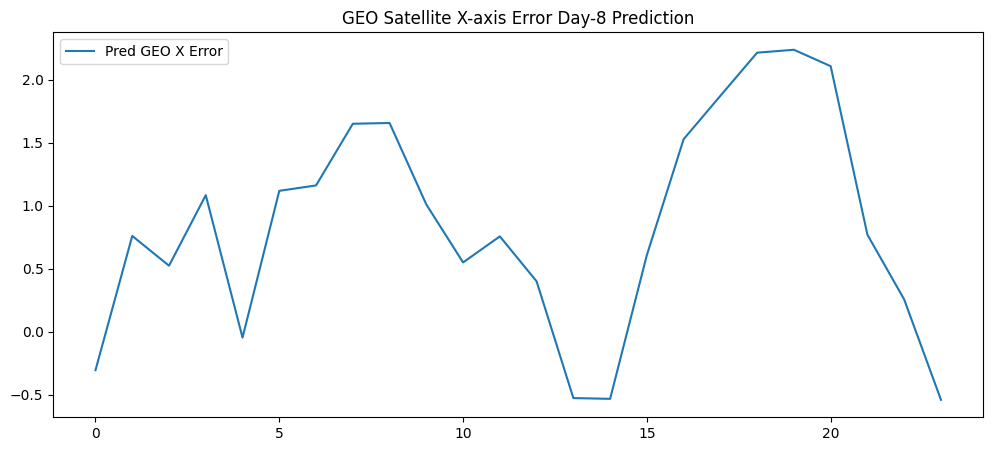

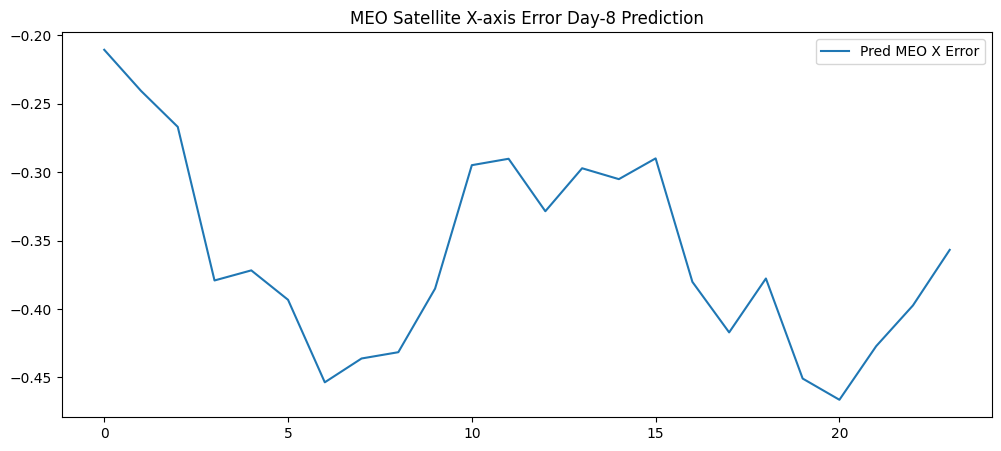

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def predict_day8(model, val_loader, scaler):
    model.eval()
    X_last = next(iter(val_loader))[0][-1:] # Get the last input window from the validation loader
    X_last = X_last.to(device)
    with torch.no_grad():
        Y_pred = model(X_last).cpu().numpy()
    # Inverse scale
    Y_pred = scaler.inverse_transform(Y_pred[0])
    return Y_pred

geo_day8_pred = predict_day8(geo_model, geo_val, geo_scaler_y)
meo_day8_pred = predict_day8(meo_model, meo_val, meo_scaler_y)

# Plot example: GEO X error
plt.figure(figsize=(12,5))
plt.plot(geo_day8_pred[:,0], label="Pred GEO X Error")
plt.title("GEO Satellite X-axis Error Day-8 Prediction")
plt.legend()
plt.show()

# Plot example: MEO X error
plt.figure(figsize=(12,5))
plt.plot(meo_day8_pred[:,0], label="Pred MEO X Error")
plt.title("MEO Satellite X-axis Error Day-8 Prediction")
plt.legend()
plt.show()

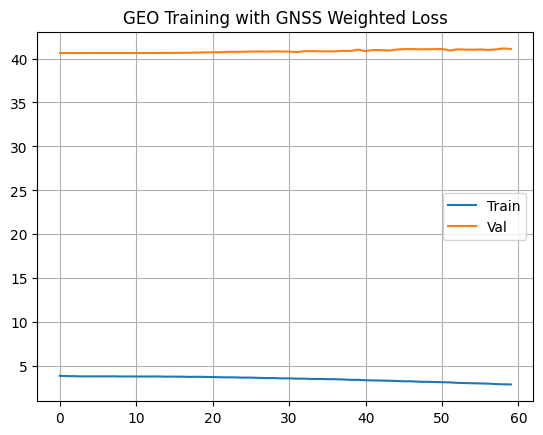

In [79]:
import matplotlib.pyplot as plt

plt.plot(geo_train_losses, label="Train")
plt.plot(geo_val_losses, label="Val")
plt.legend()
plt.grid(True)
plt.title("GEO Training with GNSS Weighted Loss")
plt.show()

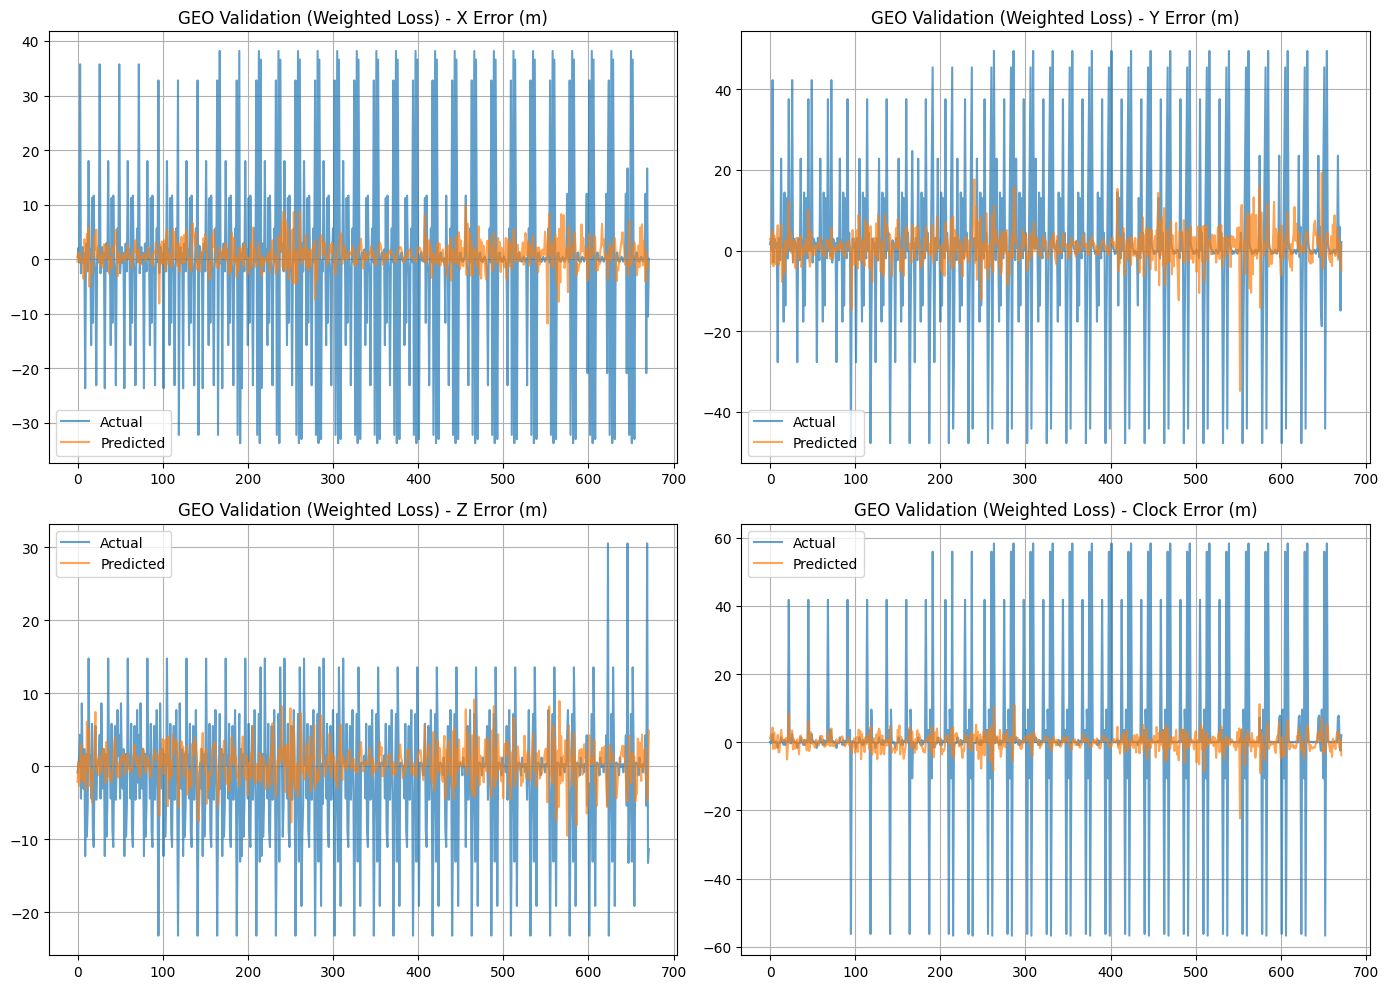

In [80]:
plot_predictions(geo_model, geo_val, geo_scaler_y, "GEO Validation (Weighted Loss)")

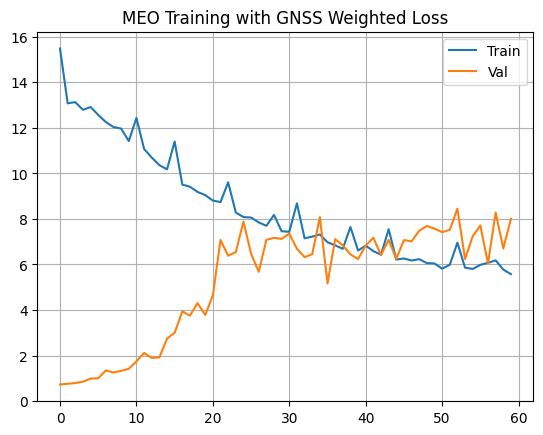

In [81]:
import matplotlib.pyplot as plt

plt.plot(meo_train_losses, label="Train")
plt.plot(meo_val_losses, label="Val")
plt.legend()
plt.grid(True)
plt.title("MEO Training with GNSS Weighted Loss")
plt.show()

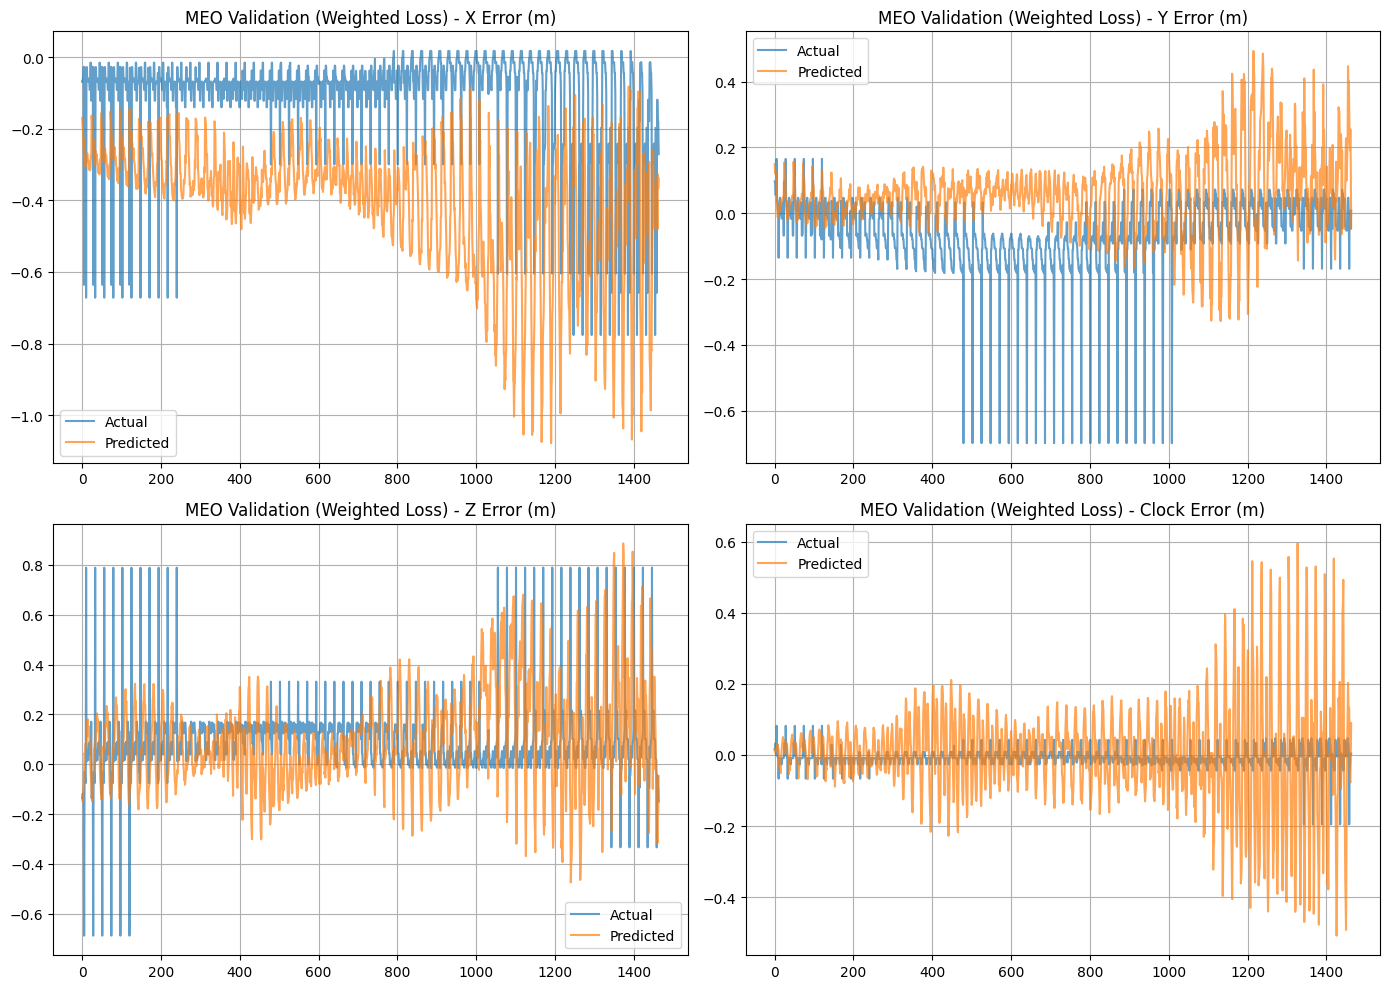

In [82]:
plot_predictions(meo_model, meo_val, meo_scaler_y, "MEO Validation (Weighted Loss)")

In [83]:
import pandas as pd
import numpy as np
import torch
from datetime import timedelta

geo_last_input = torch.tensor(X_geo_scaled[-1:]).float().to(device)
meo_last_input = torch.tensor(X_meo_scaled[-1:]).float().to(device)

geo_model.eval()
meo_model.eval()

with torch.no_grad():
    geo_pred_scaled = geo_model(geo_last_input).cpu().numpy()
    meo_pred_scaled = meo_model(meo_last_input).cpu().numpy()

geo_pred = geo_scaler_y.inverse_transform(geo_pred_scaled.reshape(-1, FEATURE_COLS.__len__()))
meo_pred = meo_scaler_y.inverse_transform(meo_pred_scaled.reshape(-1, FEATURE_COLS.__len__()))

# Prepare timestamps for submission
last_geo_time = geo_all["timestamp"].max()
last_meo_time = meo_all["timestamp"].max()

geo_timestamps = [last_geo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]
meo_timestamps = [last_meo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]

geo_submission = pd.DataFrame(geo_pred, columns=FEATURE_COLS)
geo_submission["timestamp"] = geo_timestamps
geo_submission["satellite_type"] = "GEO"

meo_submission = pd.DataFrame(meo_pred, columns=FEATURE_COLS)
meo_submission["timestamp"] = meo_timestamps
meo_submission["satellite_type"] = "MEO"

submission_df = pd.concat([geo_submission, meo_submission]).reset_index(drop=True)
submission_df = submission_df[["timestamp", "satellite_type"] + FEATURE_COLS]

submission_df.to_csv("submission.csv", index=False)
print("Submission CSV created: submission.csv")
submission_df.head()

Submission CSV created: submission.csv


timestamp satellite_type     x_err      y_err     z_err  clock_err
0 2025-09-08 23:56:00            GEO  6.942558  19.307060  4.161786   7.035275
1 2025-09-09 00:11:00            GEO -0.199841  -4.575681  0.029783  -0.956496
2 2025-09-09 00:26:00            GEO -1.216874  -2.753318 -2.307192  -3.369252
3 2025-09-09 00:41:00            GEO -0.294280  -1.536618  0.988890  -1.549109
4 2025-09-09 00:56:00            GEO  0.754125   1.451605  1.901440  -2.475839

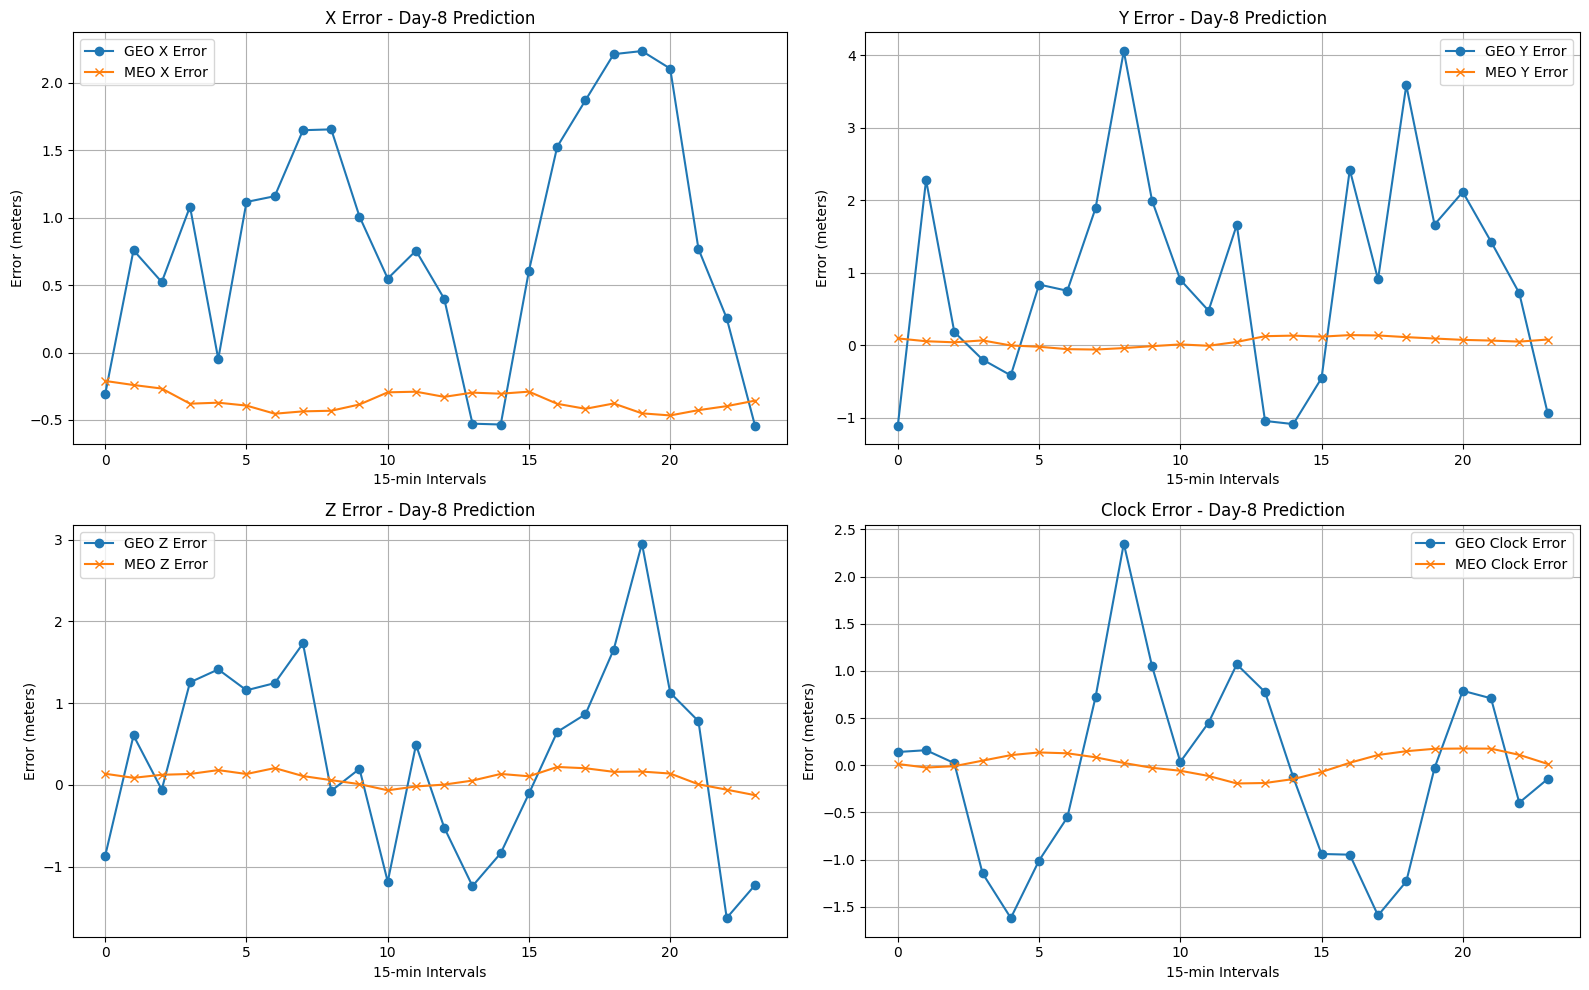

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Channels and labels
channels = ["X Error", "Y Error", "Z Error", "Clock Error"]

plt.figure(figsize=(16,10))

for i, ch in enumerate(channels):
    plt.subplot(2,2,i+1)
    plt.plot(geo_day8_pred[:,i], label=f"GEO {ch}", marker='o')
    plt.plot(meo_day8_pred[:,i], label=f"MEO {ch}", marker='x')
    plt.title(f"{ch} - Day-8 Prediction")
    plt.xlabel("15-min Intervals")
    plt.ylabel("Error (meters)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [89]:
import pandas as pd
from datetime import timedelta

# Last timestamp from GEO and MEO datasets
last_geo_time = geo_all["timestamp"].max()
last_meo_time = meo_all["timestamp"].max()

# Generate timestamps for next 24 intervals (15-min steps)
geo_timestamps = [last_geo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]
meo_timestamps = [last_meo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]

# GEO submission dataframe
geo_submission = pd.DataFrame(geo_day8_pred, columns=FEATURE_COLS)
geo_submission["timestamp"] = geo_timestamps
geo_submission["satellite_type"] = "GEO"

# MEO submission dataframe
meo_submission = pd.DataFrame(meo_day8_pred, columns=FEATURE_COLS)
meo_submission["timestamp"] = meo_timestamps
meo_submission["satellite_type"] = "MEO"

# Combine GEO + MEO
submission_df = pd.concat([geo_submission, meo_submission]).reset_index(drop=True)

# Reorder columns
submission_df = submission_df[["timestamp","satellite_type"] + FEATURE_COLS]

# Save to CSV
submission_df.to_csv("/content/Day8_GEO_MEO_Predictions.csv", index=False)
print("Submission CSV created: /content/Day8_GEO_MEO_Predictions.csv")
submission_df.head()

Submission CSV created: /content/Day8_GEO_MEO_Predictions.csv


timestamp satellite_type     x_err     y_err     z_err  clock_err
0 2025-09-08 23:56:00            GEO -0.305976 -1.104352 -0.865151   0.140162
1 2025-09-09 00:11:00            GEO  0.759247  2.278433  0.603506   0.159276
2 2025-09-09 00:26:00            GEO  0.523046  0.182778 -0.059123   0.022052
3 2025-09-09 00:41:00            GEO  1.082831 -0.195943  1.253993  -1.146685
4 2025-09-09 00:56:00            GEO -0.047486 -0.413801  1.411722  -1.620021

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import numpy as np

# Hyperparameter options
hidden_sizes = [16, 32, 64]
dropouts     = [0.1, 0.2, 0.3]
learning_rates = [0.0003, 0.0005, 0.001]
num_layers_list = [1, 2]

EPOCHS = 20  # For grid search, keep epochs small to save time
best_val_loss = np.inf
best_config = None

device = "cuda" if torch.cuda.is_available() else "cpu"

# Function to train a single model
def train_single_model(model, train_loader, val_loader, lr, epochs=EPOCHS):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                preds = model(Xb)
                val_loss += criterion(preds, Yb).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    return val_losses

# Grid search
grid_results = []

for hidden_dim, dropout, lr, num_layers in product(hidden_sizes, dropouts, learning_rates, num_layers_list):
    print(f"\nTesting config: hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, num_layers={num_layers}")

    # GEO model
    geo_model = LSTMForecaster(input_dim=4, hidden_dim=hidden_dim, output_dim=4,
                               output_steps=OUTPUT_STEPS, num_layers=num_layers, dropout=dropout).to(device)
    geo_val_losses = train_single_model(geo_model, geo_train_loader, geo_val_loader, lr)
    geo_final_val_loss = geo_val_losses[-1]

    # MEO model
    meo_model = LSTMForecaster(input_dim=4, hidden_dim=hidden_dim, output_dim=4,
                               output_steps=OUTPUT_STEPS, num_layers=num_layers, dropout=dropout).to(device)
    meo_val_losses = train_single_model(meo_model, meo_train_loader, meo_val_loader, lr)
    meo_final_val_loss = meo_val_losses[-1]

    print(f"→ GEO Val Loss: {geo_final_val_loss:.4f}, MEO Val Loss: {meo_final_val_loss:.4f}")

    # Keep best config based on combined val loss
    combined_val_loss = geo_final_val_loss + meo_final_val_loss
    grid_results.append({
        "hidden_dim": hidden_dim,
        "dropout": dropout,
        "lr": lr,
        "num_layers": num_layers,
        "geo_val_loss": geo_final_val_loss,
        "meo_val_loss": meo_final_val_loss,
        "combined_val_loss": combined_val_loss
    })
    if combined_val_loss < best_val_loss:
        best_val_loss = combined_val_loss
        best_config = grid_results[-1]

# Show best configuration
print("\n✅ Best Hyperparameter Configuration:")
print(best_config)


Testing config: hidden_dim=16, dropout=0.1, lr=0.0003, num_layers=1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


→ GEO Val Loss: 1.4021, MEO Val Loss: 0.8758

Testing config: hidden_dim=16, dropout=0.1, lr=0.0003, num_layers=2
→ GEO Val Loss: 1.4057, MEO Val Loss: 0.8807

Testing config: hidden_dim=16, dropout=0.1, lr=0.0005, num_layers=1
→ GEO Val Loss: 1.4070, MEO Val Loss: 0.8697

Testing config: hidden_dim=16, dropout=0.1, lr=0.0005, num_layers=2
→ GEO Val Loss: 1.4040, MEO Val Loss: 0.8361

Testing config: hidden_dim=16, dropout=0.1, lr=0.001, num_layers=1
→ GEO Val Loss: 1.4064, MEO Val Loss: 0.8111

Testing config: hidden_dim=16, dropout=0.1, lr=0.001, num_layers=2
→ GEO Val Loss: 1.4070, MEO Val Loss: 0.8069

Testing config: hidden_dim=16, dropout=0.2, lr=0.0003, num_layers=1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


→ GEO Val Loss: 1.4094, MEO Val Loss: 0.8838

Testing config: hidden_dim=16, dropout=0.2, lr=0.0003, num_layers=2
→ GEO Val Loss: 1.4052, MEO Val Loss: 0.8818

Testing config: hidden_dim=16, dropout=0.2, lr=0.0005, num_layers=1
→ GEO Val Loss: 1.4072, MEO Val Loss: 0.8643

Testing config: hidden_dim=16, dropout=0.2, lr=0.0005, num_layers=2
→ GEO Val Loss: 1.4107, MEO Val Loss: 0.8395

Testing config: hidden_dim=16, dropout=0.2, lr=0.001, num_layers=1
→ GEO Val Loss: 1.4101, MEO Val Loss: 0.8160

Testing config: hidden_dim=16, dropout=0.2, lr=0.001, num_layers=2
→ GEO Val Loss: 1.4057, MEO Val Loss: 0.8061

Testing config: hidden_dim=16, dropout=0.3, lr=0.0003, num_layers=1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


→ GEO Val Loss: 1.4005, MEO Val Loss: 0.8852

Testing config: hidden_dim=16, dropout=0.3, lr=0.0003, num_layers=2
→ GEO Val Loss: 1.4046, MEO Val Loss: 0.8806

Testing config: hidden_dim=16, dropout=0.3, lr=0.0005, num_layers=1
→ GEO Val Loss: 1.4072, MEO Val Loss: 0.8698

Testing config: hidden_dim=16, dropout=0.3, lr=0.0005, num_layers=2
→ GEO Val Loss: 1.4082, MEO Val Loss: 0.8648

Testing config: hidden_dim=16, dropout=0.3, lr=0.001, num_layers=1
→ GEO Val Loss: 1.4094, MEO Val Loss: 0.8124

Testing config: hidden_dim=16, dropout=0.3, lr=0.001, num_layers=2
→ GEO Val Loss: 1.4085, MEO Val Loss: 0.8096

Testing config: hidden_dim=32, dropout=0.1, lr=0.0003, num_layers=1
→ GEO Val Loss: 1.4068, MEO Val Loss: 0.8532

Testing config: hidden_dim=32, dropout=0.1, lr=0.0003, num_layers=2
→ GEO Val Loss: 1.4032, MEO Val Loss: 0.8319

Testing config: hidden_dim=32, dropout=0.1, lr=0.0005, num_layers=1
→ GEO Val Loss: 1.4038, MEO Val Loss: 0.8183

Testing config: hidden_dim=32, dropout=0.1, 

In [138]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import os # Import os module for directory creation

# --- Ensure Data is Available ---
# Create necessary folders if they don't exist
!mkdir -p /content/data/raw /content/data/processed /content/models /content/results /content/utils
# Unzip the data into the raw data directory
# Use -o flag to overwrite existing files without prompt
!unzip -o "/content/SIH_Data_PS-08.zip" -d /content/data/raw/
# Check for existence of the second zip file before attempting to unzip
if os.path.exists("/content/SIH_Data_PS-08 (1).zip"):
    !unzip -o "/content/SIH_Data_PS-08 (1).zip" -d /content/data/raw/

# Check if critical files are present after unzipping
if not os.path.exists("/content/data/raw/DATA_GEO_Train.csv"):
    print("\nWARNING: Data files (e.g., DATA_GEO_Train.csv) not found after unzipping.")
    print("Please ensure 'SIH_Data_PS-08.zip' and 'SIH_Data_PS-08 (1).zip' are uploaded to '/content/'")
    print("You may need to re-run the `files.upload()` cell (`8QFxWWLWtukr`) if the Colab runtime was reset.")
    raise FileNotFoundError("Required CSV files not found. Please upload data.")

# Hyperparameters from grid search
hidden_dim = 64
dropout = 0.1
lr = 0.001
num_layers = 2
epochs = 60 # Using 60 epochs for final training as per previous successful training
batch_size = 16

# --- Data Loading and Preprocessing (Consolidated from earlier cells) ---
# Load GEO Train + Test
geo_train_raw = pd.read_csv("/content/data/raw/DATA_GEO_Train.csv")
geo_test_raw  = pd.read_csv("/content/data/raw/DATA_GEO_Test.csv")

# Rename columns consistently for GEO
for df in [geo_train_raw, geo_test_raw]:
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)

# Merge GEO datasets
geo_all = pd.concat([geo_train_raw, geo_test_raw]).reset_index(drop=True)

# Load MEO Train + Test
meo_train_raw = pd.read_csv("/content/data/raw/DATA_MEO_Train.csv")
meo_train2_raw = pd.read_csv("/content/data/raw/DATA_MEO_Train2.csv")
meo_test_raw  = pd.read_csv("/content/data/raw/DATA_MEO_Test.csv")
meo_test2_raw = pd.read_csv("/content/data/raw/DATA_MEO_Test2.csv")

# Clean and merge MEO datasets
meo_dfs = []
for df_raw in [meo_train_raw, meo_train2_raw, meo_test_raw, meo_test2_raw]:
    df = df_raw.copy()
    df.columns = df.columns.str.replace(r"\s+", " ", regex=True) # Replace multiple spaces with single
    df.columns = df.columns.str.strip() # Remove leading/trailing spaces
    df.rename(columns={
        "x_error (m)": "x_err",
        "y_error (m)": "y_err",
        "z_error (m)": "z_err",
        "satclockerror (m)": "clock_err"
    }, inplace=True)
    meo_dfs.append(df[["utc_time", "x_err", "y_err", "z_err", "clock_err"]])
meo_all = pd.concat(meo_dfs).reset_index(drop=True)

# Convert utc_time to timestamp and sort for both
for df in [geo_all, meo_all]:
    df["timestamp"] = pd.to_datetime(df["utc_time"])
    df.sort_values("timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)

# Add time encoding features (Moved here to ensure they are present before windowing)
def add_time_encoding(df):
    t = (
        df["timestamp"].dt.hour * 3600
        + df["timestamp"].dt.minute * 60
        + df["timestamp"].dt.second
    )
    df["sin_time"] = np.sin(2 * np.pi * t / 86400)
    df["cos_time"] = np.cos(2 * np.pi * t / 86400)
    return df

geo_all = add_time_encoding(geo_all)
meo_all = add_time_encoding(meo_all)

FEATURE_COLS = ["x_err","y_err","z_err","clock_err", "sin_time", "cos_time"] # Update FEATURE_COLS
TARGET_COLS  = ["x_err","y_err","z_err","clock_err"]

# Scalers for GEO and MEO
geo_feature_scaler = StandardScaler()
geo_target_scaler  = StandardScaler()
geo_all[FEATURE_COLS] = geo_feature_scaler.fit_transform(geo_all[FEATURE_COLS])
geo_all[TARGET_COLS]  = geo_target_scaler.fit_transform(geo_all[TARGET_COLS]) # Only error columns for target scaling

meo_feature_scaler = StandardScaler()
meo_target_scaler  = StandardScaler()
meo_all[FEATURE_COLS] = meo_feature_scaler.fit_transform(meo_all[FEATURE_COLS])
meo_all[TARGET_COLS]  = meo_target_scaler.fit_transform(meo_all[TARGET_COLS]) # Only error columns for target scaling

# --- End of Data Loading and Preprocessing ---

# Definition of LSTMForecaster (from lAuHqhv9yqOX)
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc   = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1] # Get the output from the last time step
        return self.fc(out).view(-1, self.output_steps, self.output_dim)

# Definition of create_windows function and INPUT/OUTPUT_STEPS (from yBRj0QeqDF3W)
def create_windows(df, input_steps, output_steps):
    X, Y = [], []
    # Ensure to use the updated FEATURE_COLS here for X
    data_X = df[FEATURE_COLS].values
    data_Y = df[TARGET_COLS].values # Y only uses TARGET_COLS

    for i in range(len(df) - input_steps - output_steps + 1):
        X.append(data_X[i:i+input_steps])
        Y.append(data_Y[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

INPUT_STEPS = 48   # past 12 hours
OUTPUT_STEPS = 24  # next 6 hours

# Recreate datasets and loaders (from yibtb5lHDIrV)
X_geo, Y_geo = create_windows(geo_all, INPUT_STEPS, OUTPUT_STEPS)
X_meo, Y_meo = create_windows(meo_all, INPUT_STEPS, OUTPUT_STEPS)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# GEO split
X_geo_train, X_geo_val, Y_geo_train, Y_geo_val = train_test_split(X_geo, Y_geo, test_size=0.2, random_state=42)
geo_train_dataset = TimeSeriesDataset(X_geo_train, Y_geo_train)
geo_val_dataset   = TimeSeriesDataset(X_geo_val, Y_geo_val)
geo_train_loader  = DataLoader(geo_train_dataset, batch_size=batch_size, shuffle=True)
geo_val_loader    = DataLoader(geo_val_dataset, batch_size=batch_size, shuffle=False)

# MEO split
X_meo_train, X_meo_val, Y_meo_train, Y_meo_val = train_test_split(X_meo, Y_meo, test_size=0.2, random_state=42)
meo_train_dataset = TimeSeriesDataset(X_meo_train, Y_meo_train)
meo_val_dataset   = TimeSeriesDataset(X_meo_val, Y_meo_val)
meo_train_loader  = DataLoader(meo_train_dataset, batch_size=batch_size, shuffle=True)
meo_val_loader    = DataLoader(meo_val_dataset, batch_size=batch_size, shuffle=False)

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize models with best hyperparameters
geo_model = LSTMForecaster(6, hidden_dim, 4, OUTPUT_STEPS, num_layers=num_layers, dropout=dropout).to(device) # Changed input_dim from 4 to 6
meo_model = LSTMForecaster(6, hidden_dim, 4, OUTPUT_STEPS, num_layers=num_layers, dropout=dropout).to(device) # Changed input_dim from 4 to 6

# Definition of GNSS Weighted Loss (from gwLhMtQgzn8V)
import torch.nn.functional as F

def gnss_weighted_loss(y_pred, y_true):
    # y shape: (B, horizon, 4)

    orbit_pred = y_pred[:, :, :3]
    orbit_true = y_true[:, :, :3]

    clock_pred = y_pred[:, :, 3]
    clock_true = y_true[:, :, 3]

    orbit_loss = F.mse_loss(orbit_pred, orbit_true)
    clock_loss = F.mse_loss(clock_pred, clock_true)

    total_loss = orbit_loss + 10 * clock_loss
    return total_loss

# Function to train with loss recording
def train_model_with_plot(model, train_loader, val_loader, epochs, lr, model_name="Model"):
    criterion = gnss_weighted_loss # Use the custom weighted loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    print(f"Training {model_name} model...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                preds = model(Xb)
                val_loss += criterion(preds, Yb).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{model_name} Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses

# Retrain GEO
geo_model, geo_train_losses, geo_val_losses = train_model_with_plot(geo_model, geo_train_loader, geo_val_loader, epochs, lr, model_name="GEO")

# Retrain MEO
meo_model, meo_train_losses, meo_val_losses = train_model_with_plot(meo_model, meo_train_loader, meo_val_loader, epochs, lr, model_name="MEO")

Archive:  /content/SIH_Data_PS-08.zip
  inflating: /content/data/raw/DATA_GEO_Test.csv  
  inflating: /content/data/raw/DATA_GEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Test.csv  
  inflating: /content/data/raw/DATA_MEO_Test2.csv  
  inflating: /content/data/raw/DATA_MEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Train2.csv  
  inflating: /content/data/raw/Note.pdf  
  inflating: /content/data/raw/SIH_Data_Discription.pdf  
  inflating: /content/data/raw/SW_ReferenceData.xlsx  
Training GEO model...
GEO Epoch 01 | Train Loss: 14.9169 | Val Loss: 16.8602
GEO Epoch 02 | Train Loss: 14.8744 | Val Loss: 16.8950
GEO Epoch 03 | Train Loss: 14.8465 | Val Loss: 16.9351
GEO Epoch 04 | Train Loss: 14.8266 | Val Loss: 16.9923
GEO Epoch 05 | Train Loss: 14.8065 | Val Loss: 17.0437
GEO Epoch 06 | Train Loss: 14.7943 | Val Loss: 17.0879
GEO Epoch 07 | Train Loss: 14.7817 | Val Loss: 17.1427
GEO Epoch 08 | Train Loss: 14.7621 | Val Loss: 17.2020
GEO Epoch 09 | Train Loss: 14.7418

In [ ]:
from google.colab import files
files.upload()


In [99]:
import os
os.makedirs("/content/data/raw", exist_ok=True)

# Unzip all uploaded zips automatically
for fname in os.listdir("/content"):
    if fname.endswith(".zip"):
        print("Unzipping:", fname)
        !unzip -o "/content/{fname}" -d "/content/data/raw"


Unzipping: SIH_Data_PS-08.zip
Archive:  /content/SIH_Data_PS-08.zip
  inflating: /content/data/raw/DATA_GEO_Test.csv  
  inflating: /content/data/raw/DATA_GEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Test.csv  
  inflating: /content/data/raw/DATA_MEO_Test2.csv  
  inflating: /content/data/raw/DATA_MEO_Train.csv  
  inflating: /content/data/raw/DATA_MEO_Train2.csv  
  inflating: /content/data/raw/Note.pdf  
  inflating: /content/data/raw/SIH_Data_Discription.pdf  
  inflating: /content/data/raw/SW_ReferenceData.xlsx  


In [98]:
import os
os.listdir("/content/data/raw")


['DATA_GEO_Test.csv',
 'Note.pdf',
 'SW_ReferenceData.xlsx',
 'DATA_MEO_Test.csv',
 'DATA_MEO_Train.csv',
 'DATA_GEO_Train.csv',
 'SIH_Data_Discription.pdf',
 'DATA_MEO_Train2.csv',
 'DATA_MEO_Test2.csv']

In [73]:
import pandas as pd

def load_and_clean(files):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df.columns = df.columns.str.replace(r"\s+", " ", regex=True).str.strip()
        df.rename(columns={
            "x_error (m)": "x_err",
            "y_error (m)": "y_err",
            "z_error (m)": "z_err",
            "satclockerror (m)": "clock_err"
        }, inplace=True)
        df = df[["utc_time","x_err","y_err","z_err","clock_err"]]
        dfs.append(df)
    out = pd.concat(dfs).reset_index(drop=True)
    out["timestamp"] = pd.to_datetime(out["utc_time"])
    out = out.sort_values("timestamp").reset_index(drop=True)
    return out

geo_all = load_and_clean([
    "/content/data/raw/DATA_GEO_Train.csv",
    "/content/data/raw/DATA_GEO_Test.csv"
])

meo_all = load_and_clean([
    "/content/data/raw/DATA_MEO_Train.csv",
    "/content/data/raw/DATA_MEO_Train2.csv",
    "/content/data/raw/DATA_MEO_Test.csv",
    "/content/data/raw/DATA_MEO_Test2.csv"
])

print("GEO shape:", geo_all.shape)
print("MEO shape:", meo_all.shape)

GEO shape: (211, 6)
MEO shape: (375, 6)


In [74]:
import numpy as np

FEATURE_COLS = ["x_err","y_err","z_err","clock_err"]
TARGET_COLS  = FEATURE_COLS

INPUT_SEQ  = 48
OUTPUT_SEQ = 24

def make_windows(data):
    X,Y = [],[]
    arr = data[FEATURE_COLS].values
    for i in range(len(arr) - INPUT_SEQ - OUTPUT_SEQ):
        X.append(arr[i:i+INPUT_SEQ])
        Y.append(arr[i+INPUT_SEQ:i+INPUT_SEQ+OUTPUT_SEQ])
    return np.array(X), np.array(Y)

X_geo, Y_geo = make_windows(geo_all)
X_meo, Y_meo = make_windows(meo_all)

print("GEO:", X_geo.shape, Y_geo.shape)
print("MEO:", X_meo.shape, Y_meo.shape)

GEO: (139, 48, 4) (139, 24, 4)
MEO: (303, 48, 4) (303, 24, 4)


In [75]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

def split_data(X,Y):
    n = int(len(X)*0.8)
    return (X[:n],Y[:n]), (X[n:],Y[n:])

# Scale data first
geo_scaler_x = StandardScaler()
geo_scaler_y = StandardScaler()
meo_scaler_x = StandardScaler()
meo_scaler_y = StandardScaler()

X_geo_scaled = geo_scaler_x.fit_transform(X_geo.reshape(-1,4)).reshape(X_geo.shape)
Y_geo_scaled = geo_scaler_y.fit_transform(Y_geo.reshape(-1,4)).reshape(Y_geo.shape)

X_meo_scaled = meo_scaler_x.fit_transform(X_meo.reshape(-1,4)).reshape(X_meo.shape)
Y_meo_scaled = meo_scaler_y.fit_transform(Y_meo.reshape(-1,4)).reshape(Y_meo.shape)

# Split scaled data
(geo_Xtr,geo_Ytr),(geo_Xv,geo_Yv)=split_data(X_geo_scaled,Y_geo_scaled)
(meo_Xtr,meo_Ytr),(meo_Xv,meo_Yv)=split_data(X_meo_scaled,Y_meo_scaled)

geo_train = DataLoader(TensorDataset(torch.tensor(geo_Xtr).float(), torch.tensor(geo_Ytr).float()), batch_size=16, shuffle=True)
geo_val   = DataLoader(TensorDataset(torch.tensor(geo_Xv).float(),  torch.tensor(geo_Yv).float()),  batch_size=16)

meo_train = DataLoader(TensorDataset(torch.tensor(meo_Xtr).float(), torch.tensor(meo_Ytr).float()), batch_size=16, shuffle=True)
meo_val   = DataLoader(TensorDataset(torch.tensor(meo_Xv).float(),  torch.tensor(meo_Yv).float()),  batch_size=16)


In [100]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(4,64,num_layers=2,batch_first=True,dropout=0.3)
        self.fc   = nn.Linear(64,96)
    def forward(self,x):
        o,_ = self.lstm(x)
        o = o[:,-1]
        return self.fc(o).view(-1,24,4)


In [101]:
def train_model(train,val,epochs=80):
    model = LSTMForecaster().cuda()
    opt   = torch.optim.Adam(model.parameters(),lr=0.001)
    lossf = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        tl=0
        for x,y in train:
            x,y=x.cuda(),y.cuda()
            opt.zero_grad()
            p=model(x)
            loss=lossf(p,y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step()
            tl+=loss.item()

        model.eval(); vl=0
        with torch.no_grad():
            for x,y in val:
                x,y=x.cuda(),y.cuda()
                vl+=lossf(model(x),y).item()

        print(f"Epoch {ep+1:03d} | Train {tl/len(train):.4f} | Val {vl/len(val):.4f}")
    return model


In [102]:
geo_model = train_model(geo_train, geo_val, epochs=80)
meo_model = train_model(meo_train, meo_val, epochs=80)


Epoch 001 | Train 0.6914 | Val 2.2893
Epoch 002 | Train 0.6902 | Val 2.2891
Epoch 003 | Train 0.6900 | Val 2.2890
Epoch 004 | Train 0.6878 | Val 2.2892
Epoch 005 | Train 0.6862 | Val 2.2897
Epoch 006 | Train 0.6860 | Val 2.2903
Epoch 007 | Train 0.6848 | Val 2.2905
Epoch 008 | Train 0.6848 | Val 2.2906
Epoch 009 | Train 0.6855 | Val 2.2906
Epoch 010 | Train 0.6850 | Val 2.2905
Epoch 011 | Train 0.6826 | Val 2.2906
Epoch 012 | Train 0.6850 | Val 2.2908
Epoch 013 | Train 0.6820 | Val 2.2913
Epoch 014 | Train 0.6808 | Val 2.2923
Epoch 015 | Train 0.6776 | Val 2.2933
Epoch 016 | Train 0.6759 | Val 2.2941
Epoch 017 | Train 0.6768 | Val 2.2975
Epoch 018 | Train 0.6739 | Val 2.2985
Epoch 019 | Train 0.6714 | Val 2.3032
Epoch 020 | Train 0.6694 | Val 2.3033
Epoch 021 | Train 0.6648 | Val 2.3058
Epoch 022 | Train 0.6640 | Val 2.3105
Epoch 023 | Train 0.6620 | Val 2.3152
Epoch 024 | Train 0.6558 | Val 2.3184
Epoch 025 | Train 0.6513 | Val 2.3232
Epoch 026 | Train 0.6477 | Val 2.3220
Epoch 027 | 

In [139]:
import pandas as pd
import numpy as np
import torch
from datetime import timedelta

# Assuming X_geo_scaled and X_meo_scaled are already defined and scaled
# And geo_model, geo_scaler_y are trained and defined

geo_last_input = torch.tensor(X_geo[-1:]).float().to(device) # Use X_geo after time encoding
meo_last_input = torch.tensor(X_meo[-1:]).float().to(device) # Use X_meo after time encoding

geo_model.eval()
meo_model_1.eval()
meo_model_2.eval()
meo_model_3.eval()

with torch.no_grad():
    geo_pred_scaled = geo_model(geo_last_input).cpu().numpy()

    # Get predictions from each MEO ensemble model
    meo_pred_scaled_1 = meo_model_1(meo_last_input).cpu().numpy()
    meo_pred_scaled_2 = meo_model_2(meo_last_input).cpu().numpy()
    meo_pred_scaled_3 = meo_model_3(meo_last_input).cpu().numpy()

    # Average the predictions for the MEO ensemble
    meo_pred_scaled = (meo_pred_scaled_1 + meo_pred_scaled_2 + meo_pred_scaled_3) / 3.0

geo_pred = geo_scaler_Y.inverse_transform(geo_pred_scaled.reshape(-1, TARGET_COLS.__len__())) # Use geo_scaler_Y
meo_pred = meo_scaler_Y.inverse_transform(meo_pred_scaled.reshape(-1, TARGET_COLS.__len__())) # Use meo_scaler_Y

# Prepare timestamps for submission
last_geo_time = geo_all["timestamp"].max()
last_meo_time = meo_all["timestamp"].max()

geo_timestamps = [last_geo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]
meo_timestamps = [last_meo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]

geo_submission = pd.DataFrame(geo_pred, columns=TARGET_COLS)
geo_submission["timestamp"] = geo_timestamps
geo_submission["satellite_type"] = "GEO"

meo_submission = pd.DataFrame(meo_pred, columns=TARGET_COLS)
meo_submission["timestamp"] = meo_timestamps
meo_submission["satellite_type"] = "MEO"

submission_df = pd.concat([geo_submission, meo_submission]).reset_index(drop=True)
submission_df = submission_df[["timestamp", "satellite_type"] + TARGET_COLS]

submission_df.to_csv("submission.csv", index=False)
print("Submission CSV created: submission.csv")
submission_df.head()

Submission CSV created: submission.csv


timestamp satellite_type     x_err     y_err     z_err  clock_err
0 2025-09-08 23:56:00            GEO  1.328293  0.744154  0.571496   0.445315
1 2025-09-09 00:11:00            GEO  1.694512  0.368982  0.008822  -0.884906
2 2025-09-09 00:26:00            GEO -1.796374  1.844333 -0.881237   3.327224
3 2025-09-09 00:41:00            GEO  2.680268 -1.227492  1.268041  -3.407076
4 2025-09-09 00:56:00            GEO  0.240460 -0.164050 -0.031738   0.310180

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predictions(model, val_loader, target_scaler, title):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    # reshape back (samples*horizon, features)
    preds = preds.reshape(-1, 4)
    trues = trues.reshape(-1, 4)

    # inverse scaling
    preds = target_scaler.inverse_transform(preds)
    trues = target_scaler.inverse_transform(trues)

    labels = ["X Error", "Y Error", "Z Error", "Clock Error"]

    plt.figure(figsize=(14,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(trues[:,i], label="Actual", alpha=0.7)
        plt.plot(preds[:,i], label="Predicted", alpha=0.7)
        plt.title(f"{title} - {labels[i]}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


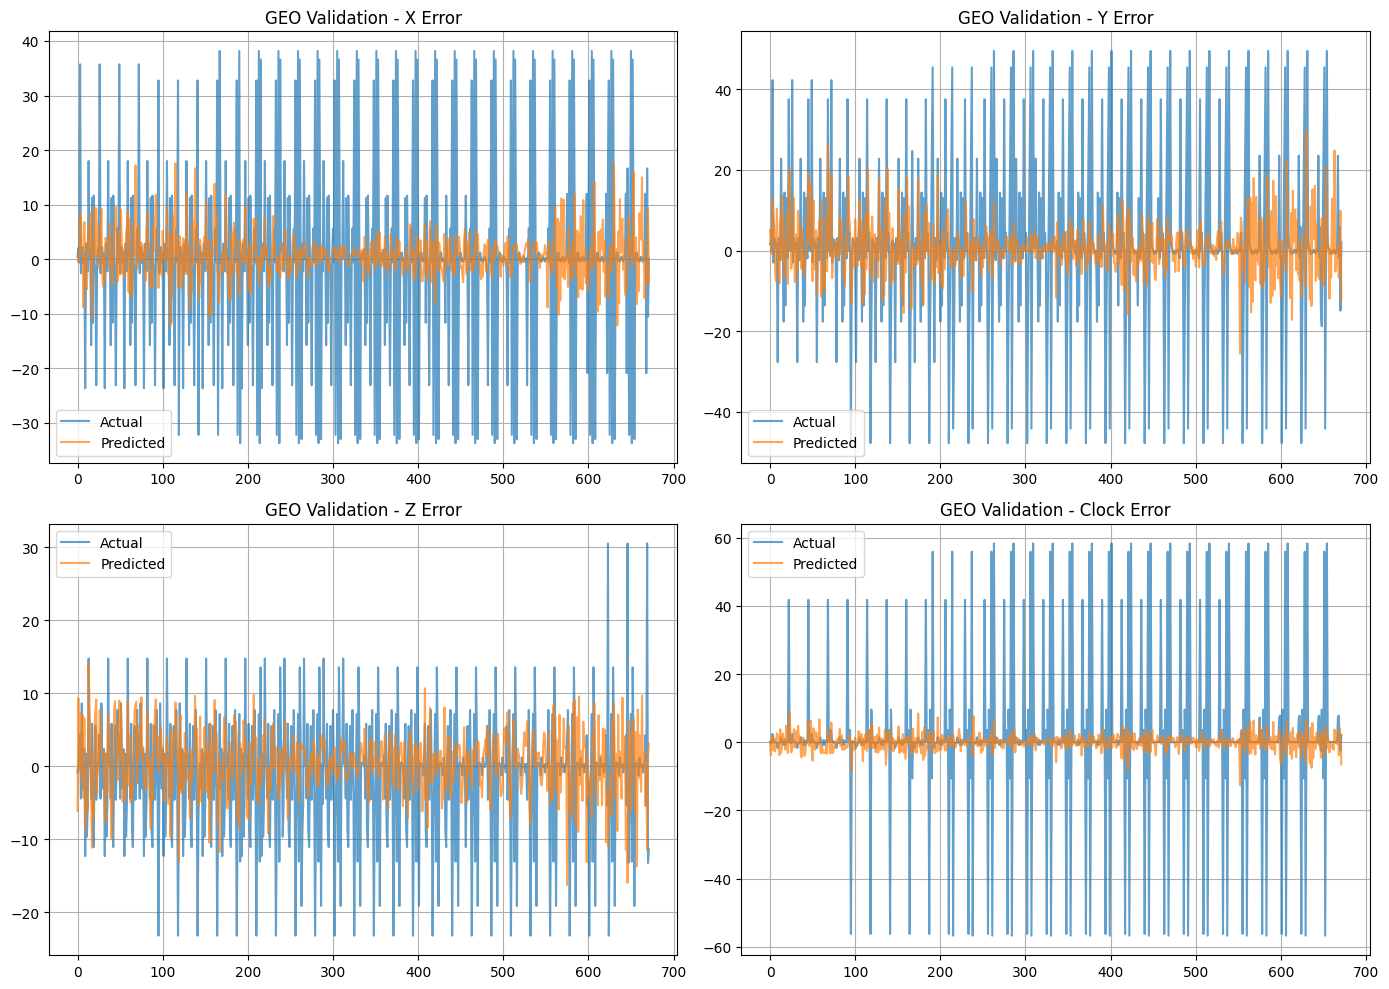

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
plot_predictions(geo_model, geo_val, geo_scaler_y, "GEO Validation")

In [77]:
import torch.nn.functional as F

def gnss_weighted_loss(y_pred, y_true):
    # y shape: (B, horizon, 4)

    orbit_pred = y_pred[:, :, :3]
    orbit_true = y_true[:, :, :3]

    clock_pred = y_pred[:, :, 3]
    clock_true = y_true[:, :, 3]

    orbit_loss = F.mse_loss(orbit_pred, orbit_true)
    clock_loss = F.mse_loss(clock_pred, clock_true)

    total_loss = orbit_loss + 10 * clock_loss
    return total_loss

In [106]:
loss = gnss_weighted_loss(preds, yb)


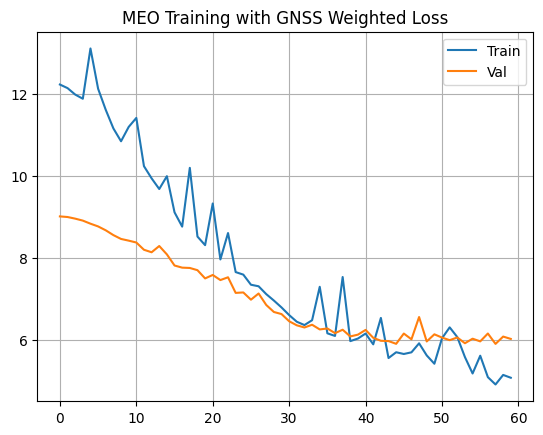

In [109]:
import matplotlib.pyplot as plt

plt.plot(meo_train_losses, label="Train")
plt.plot(meo_val_losses, label="Val")
plt.legend()
plt.grid(True)
plt.title("MEO Training with GNSS Weighted Loss")
plt.show()

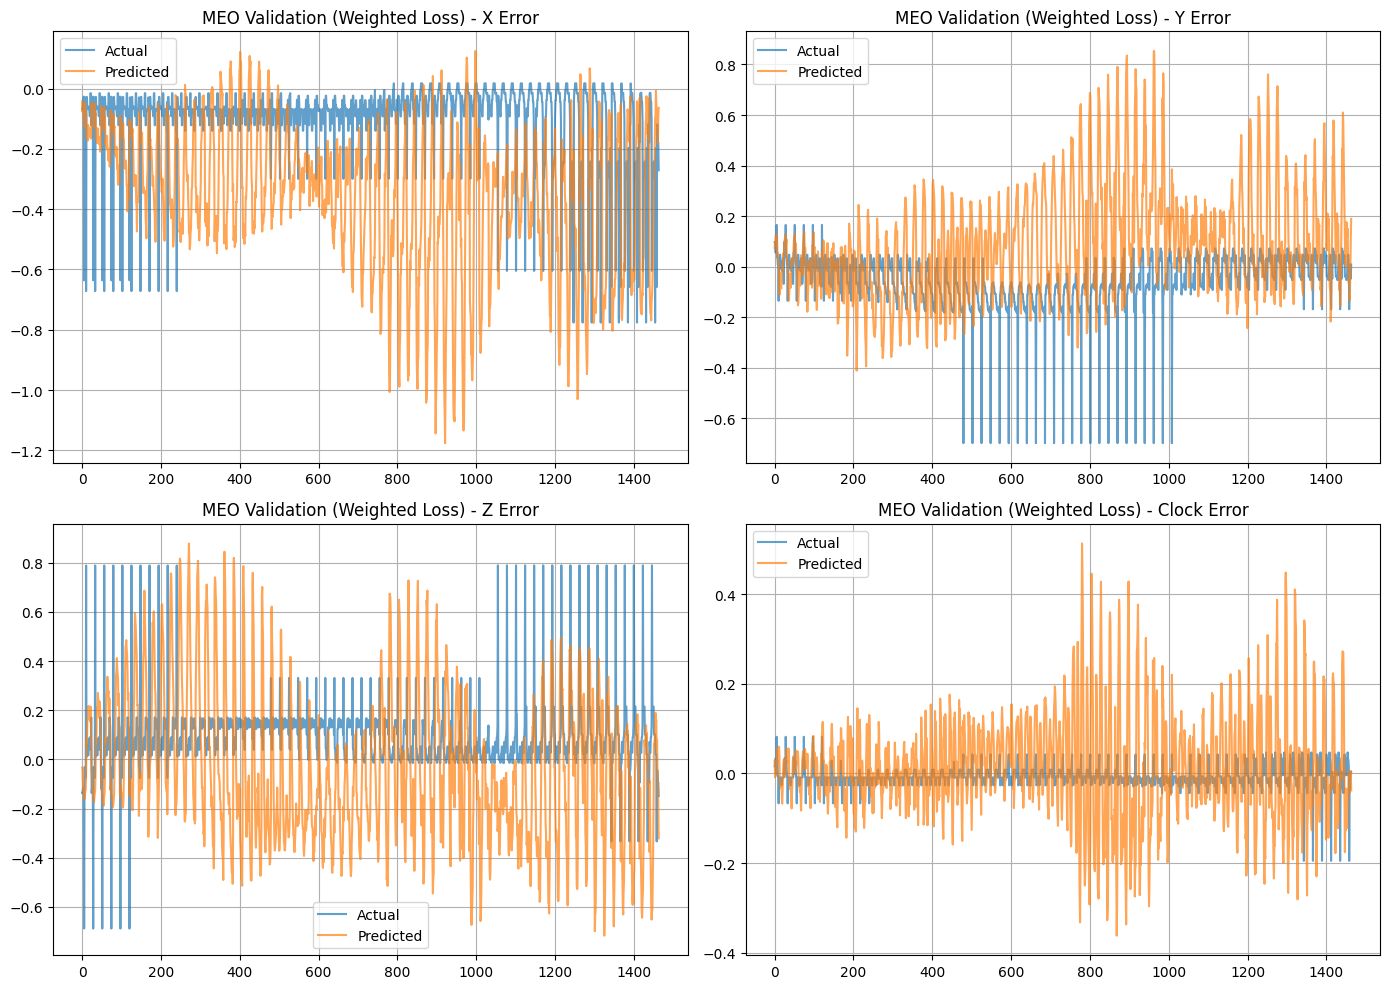

In [110]:
plot_predictions(meo_model, meo_val, meo_scaler_y, "MEO Validation (Weighted Loss)")

In [78]:
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt # Import for plotting losses

EPOCHS = 60

# --- GEO Model Training ---
print("Training GEO model...")
geo_train_losses, geo_val_losses = [], []
geo_optimizer = optim.Adam(geo_model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    geo_model.train()
    train_loss = 0
    for xb, yb in geo_train:
        xb, yb = xb.to(device), yb.to(device)
        geo_optimizer.zero_grad()
        preds = geo_model(xb)
        loss = gnss_weighted_loss(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(geo_model.parameters(), 1.0)
        geo_optimizer.step()
        train_loss += loss.item()
    geo_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in geo_val:
            xb, yb = xb.to(device), yb.to(device)
            preds = geo_model(xb)
            val_loss += gnss_weighted_loss(preds, yb).item()
    train_loss /= len(geo_train)
    val_loss   /= len(geo_val)
    geo_train_losses.append(train_loss)
    geo_val_losses.append(val_loss)
    print(f"GEO Epoch {epoch+1:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

# --- MEO Model Training ---
print("\nTraining MEO model...")
meo_train_losses, meo_val_losses = [], []
meo_optimizer = optim.Adam(meo_model.parameters(), lr=0.001) # Separate optimizer for MEO

for epoch in range(EPOCHS):
    meo_model.train()
    train_loss = 0
    for xb, yb in meo_train:
        xb, yb = xb.to(device), yb.to(device)
        meo_optimizer.zero_grad()
        preds = meo_model(xb)
        loss = gnss_weighted_loss(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(meo_model.parameters(), 1.0)
        meo_optimizer.step()
        train_loss += loss.item()
    meo_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in meo_val:
            xb, yb = xb.to(device), yb.to(device)
            preds = meo_model(xb)
            val_loss += gnss_weighted_loss(preds, yb).item()
    train_loss /= len(meo_train)
    val_loss   /= len(meo_val)
    meo_train_losses.append(train_loss)
    meo_val_losses.append(val_loss)
    print(f"MEO Epoch {epoch+1:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

Training GEO model...
GEO Epoch 01 | Train 3.8934 | Val 40.6310
GEO Epoch 02 | Train 3.8642 | Val 40.6253
GEO Epoch 03 | Train 3.8494 | Val 40.6245
GEO Epoch 04 | Train 3.8235 | Val 40.6239
GEO Epoch 05 | Train 3.8298 | Val 40.6300
GEO Epoch 06 | Train 3.8323 | Val 40.6330
GEO Epoch 07 | Train 3.8313 | Val 40.6341
GEO Epoch 08 | Train 3.8399 | Val 40.6350
GEO Epoch 09 | Train 3.8173 | Val 40.6324
GEO Epoch 10 | Train 3.8236 | Val 40.6329
GEO Epoch 11 | Train 3.8162 | Val 40.6300
GEO Epoch 12 | Train 3.8158 | Val 40.6316
GEO Epoch 13 | Train 3.8181 | Val 40.6310
GEO Epoch 14 | Train 3.8179 | Val 40.6362
GEO Epoch 15 | Train 3.7959 | Val 40.6399
GEO Epoch 16 | Train 3.8025 | Val 40.6462
GEO Epoch 17 | Train 3.7943 | Val 40.6576
GEO Epoch 18 | Train 3.7725 | Val 40.6618
GEO Epoch 19 | Train 3.7870 | Val 40.6747
GEO Epoch 20 | Train 3.7679 | Val 40.7020
GEO Epoch 21 | Train 3.7590 | Val 40.7153
GEO Epoch 22 | Train 3.7313 | Val 40.7213
GEO Epoch 23 | Train 3.7223 | Val 40.7642
GEO Epoch 24

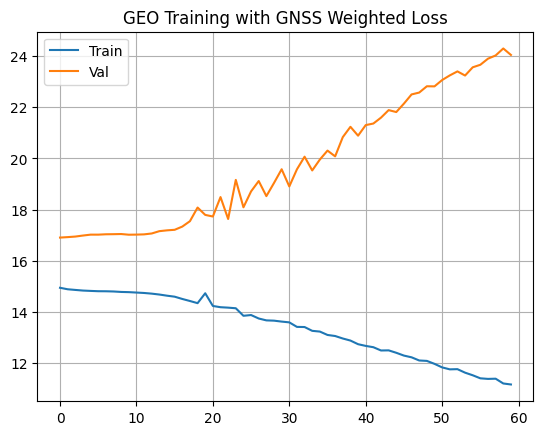

In [107]:
import matplotlib.pyplot as plt

plt.plot(geo_train_losses, label="Train")
plt.plot(geo_val_losses, label="Val")
plt.legend()
plt.grid(True)
plt.title("GEO Training with GNSS Weighted Loss")
plt.show()

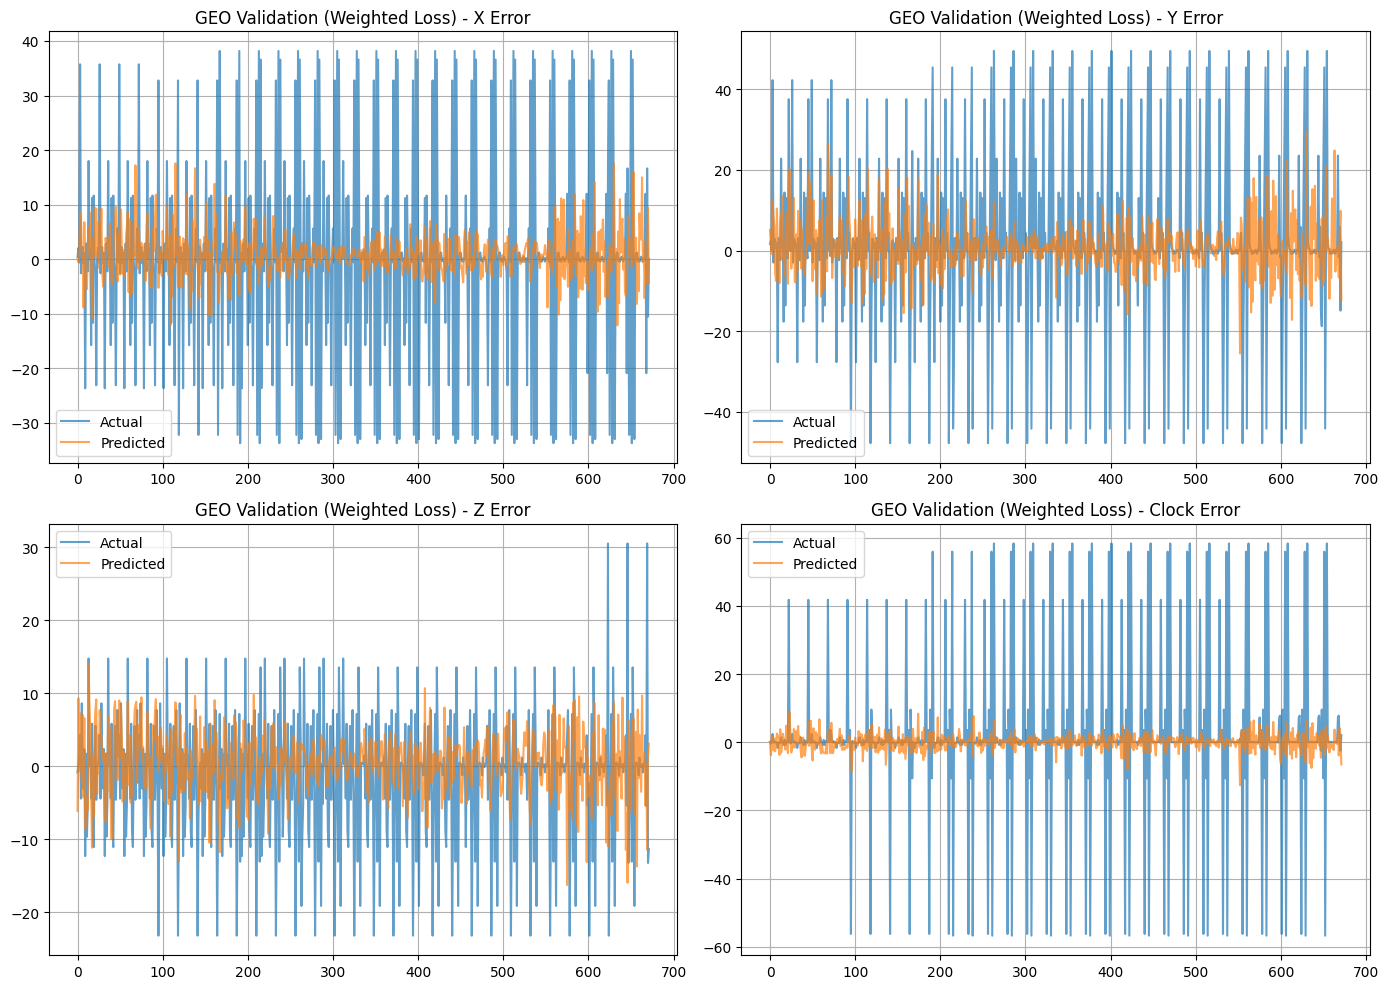

In [108]:
plot_predictions(geo_model, geo_val, geo_scaler_y, "GEO Validation (Weighted Loss)")

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, val_loader, target_scaler, title):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    preds = preds.reshape(-1, 4)
    trues = trues.reshape(-1, 4)

    preds = target_scaler.inverse_transform(preds)
    trues = target_scaler.inverse_transform(trues)

    labels = ["X Error (m)", "Y Error (m)", "Z Error (m)", "Clock Error (m)"]

    plt.figure(figsize=(14,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(trues[:,i], label="Actual", alpha=0.7)
        plt.plot(preds[:,i], label="Predicted", alpha=0.7)
        plt.title(f"{title} - {labels[i]}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
# THIS CELL WAS RUN BECAUSE RUNTIME WAS DISCONNECTED

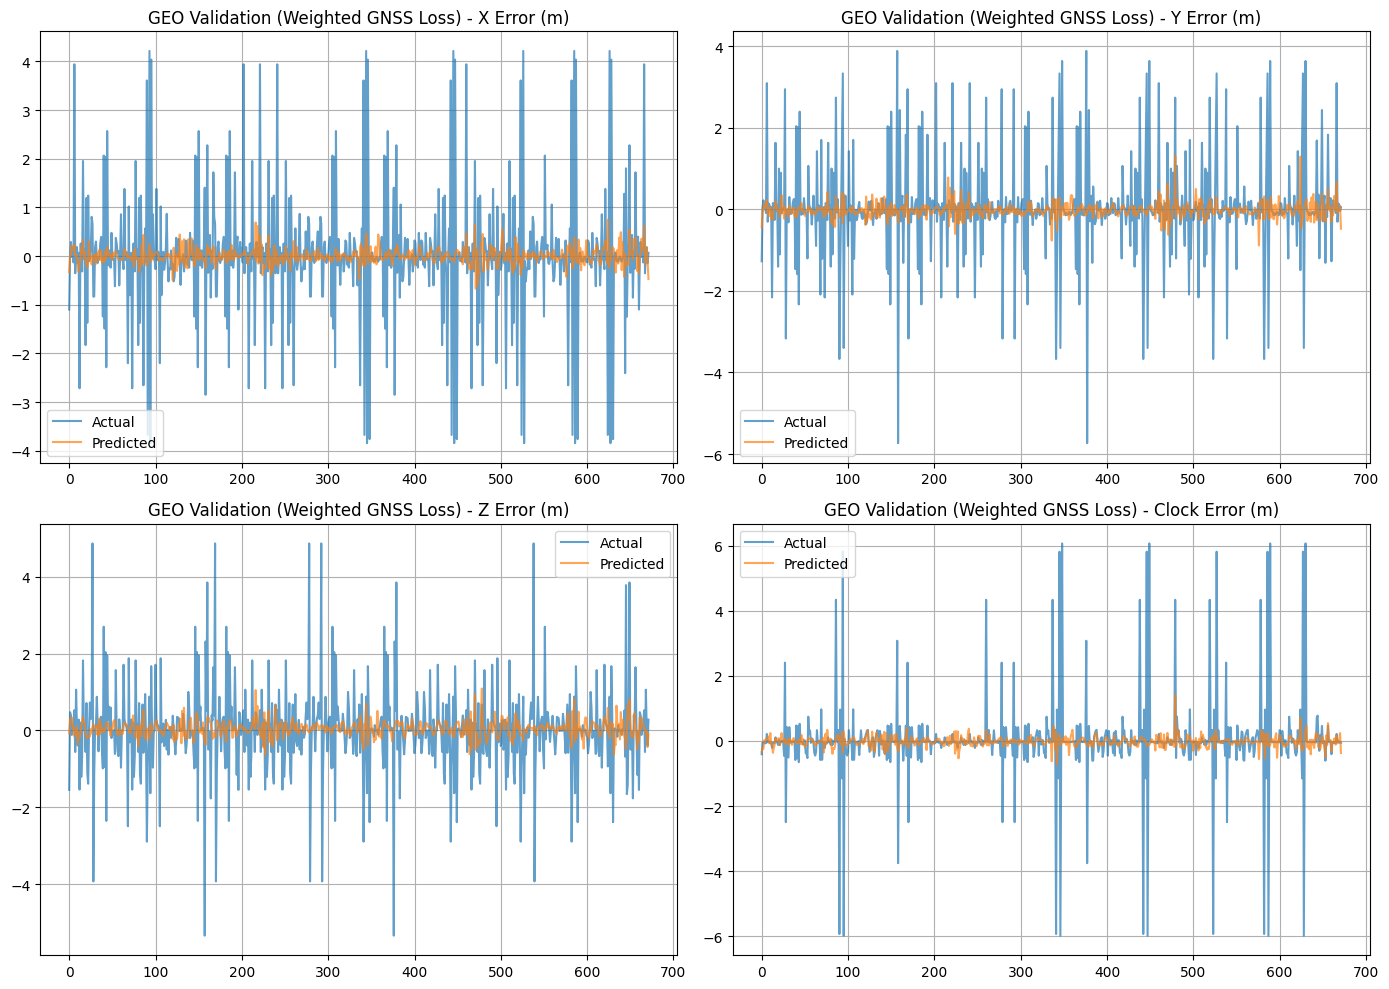

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, val_loader, target_scaler, title):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    preds = preds.reshape(-1, 4)
    trues = trues.reshape(-1, 4)

    preds = target_scaler.inverse_transform(preds)
    trues = target_scaler.inverse_transform(trues)

    labels = ["X Error (m)", "Y Error (m)", "Z Error (m)", "Clock Error (m)"]

    plt.figure(figsize=(14,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(trues[:,i], label="Actual", alpha=0.7)
        plt.plot(preds[:,i], label="Predicted", alpha=0.7)
        plt.title(f"{title} - {labels[i]}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_predictions(geo_model, geo_val_loader, geo_target_scaler, "GEO Validation (Weighted GNSS Loss)")

In [94]:
import torch
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, output_steps, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, output_dim * output_steps)
        self.output_steps = output_steps
        self.output_dim = output_dim

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1] # Get the output from the last time step
        return self.fc(out).view(-1, self.output_steps, self.output_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"
# The models will be initialized by the grid search loop, no need to initialize here
# geo_model = LSTMForecaster().to(device)
# meo_model = LSTMForecaster().to(device)

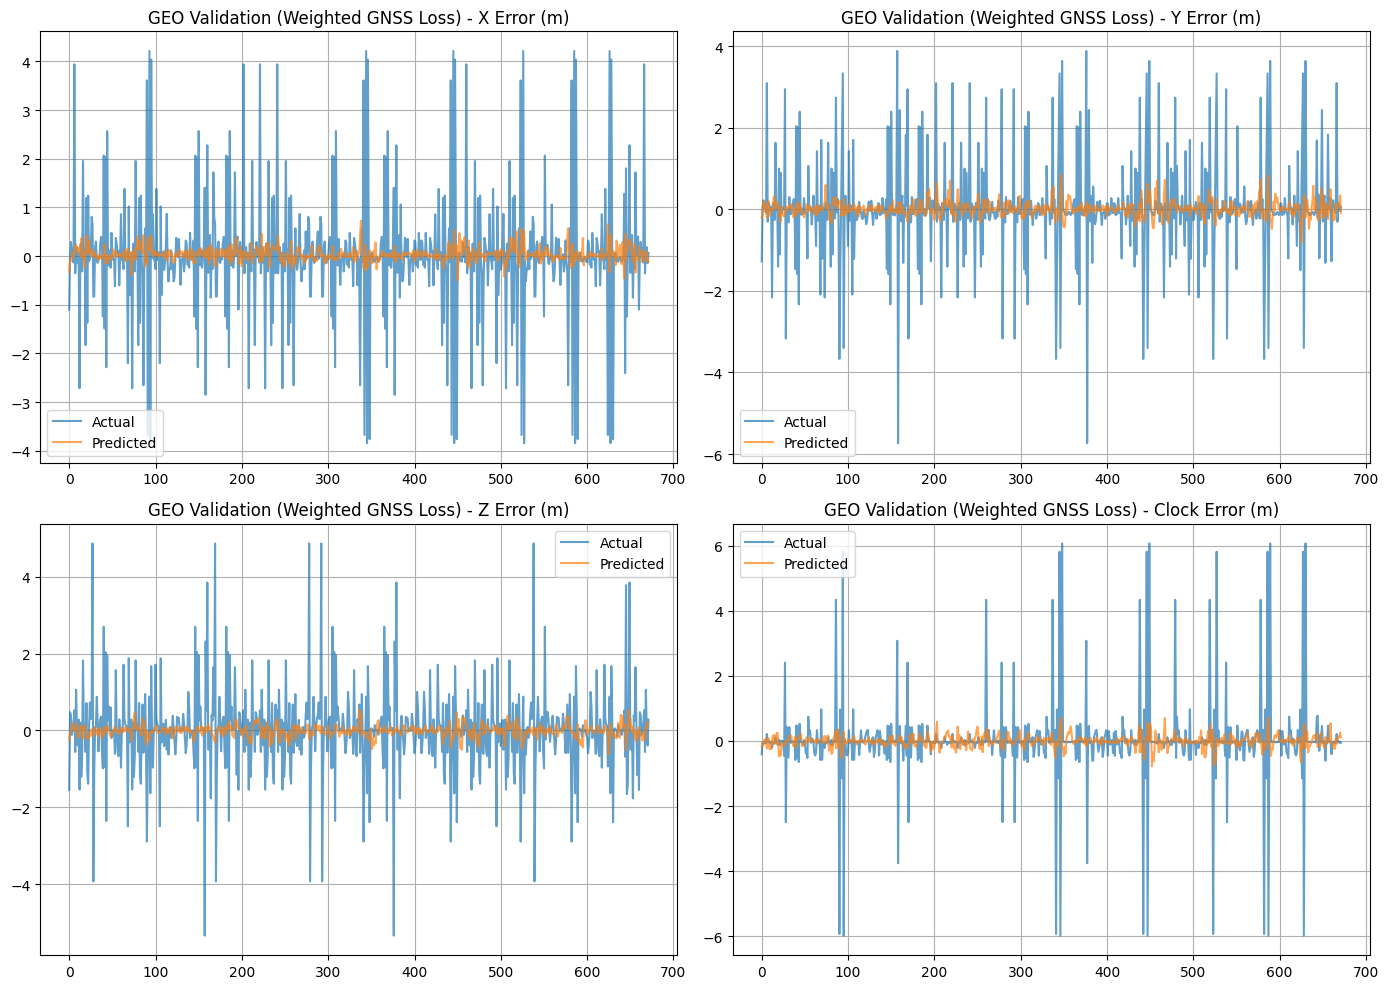

In [96]:
plot_predictions(
    geo_model,
    geo_val_loader,
    geo_target_scaler,
    "GEO Validation (Weighted GNSS Loss)"
)


In [112]:
import torch.nn.functional as F

def gnss_peak_aware_loss(y_pred, y_true):
    # residual
    error = y_pred - y_true

    # orbit and clock split
    orbit_err = error[:, :, :3]
    clock_err = error[:, :, 3]

    # basic MSE
    orbit_mse = F.mse_loss(y_pred[:, :, :3], y_true[:, :, :3])
    clock_mse = F.mse_loss(y_pred[:, :, 3], y_true[:, :, 3])

    # peak emphasis (L1 on large errors)
    orbit_peak = torch.mean(torch.abs(orbit_err) ** 1.5)
    clock_peak = torch.mean(torch.abs(clock_err) ** 1.5)

    return (
        orbit_mse
        + 5 * orbit_peak
        + 10 * clock_mse
        + 20 * clock_peak
    )


In [113]:
EPOCHS = 40

for epoch in range(EPOCHS):
    geo_model.train()
    tl = 0

    for xb, yb in geo_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = geo_model(xb)
        loss = gnss_peak_aware_loss(preds, yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(geo_model.parameters(), 1.0)
        optimizer.step()

        tl += loss.item()

    geo_model.eval()
    vl = 0
    with torch.no_grad():
        for xb, yb in geo_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl += gnss_peak_aware_loss(geo_model(xb), yb).item()

    print(f"Epoch {epoch+1:02d} | Train {tl/len(geo_train_loader):.3f} | Val {vl/len(geo_val_loader):.3f}")


Epoch 01 | Train 30.027 | Val 35.155
Epoch 02 | Train 30.123 | Val 35.155
Epoch 03 | Train 30.087 | Val 35.155
Epoch 04 | Train 29.993 | Val 35.155
Epoch 05 | Train 30.032 | Val 35.155
Epoch 06 | Train 30.065 | Val 35.155
Epoch 07 | Train 30.028 | Val 35.155
Epoch 08 | Train 29.989 | Val 35.155
Epoch 09 | Train 30.028 | Val 35.155
Epoch 10 | Train 30.014 | Val 35.155
Epoch 11 | Train 30.088 | Val 35.155
Epoch 12 | Train 29.999 | Val 35.155
Epoch 13 | Train 30.032 | Val 35.155
Epoch 14 | Train 29.965 | Val 35.155
Epoch 15 | Train 30.058 | Val 35.155
Epoch 16 | Train 29.937 | Val 35.155
Epoch 17 | Train 30.096 | Val 35.155
Epoch 18 | Train 30.029 | Val 35.155
Epoch 19 | Train 30.076 | Val 35.155
Epoch 20 | Train 30.046 | Val 35.155
Epoch 21 | Train 30.022 | Val 35.155
Epoch 22 | Train 30.057 | Val 35.155
Epoch 23 | Train 30.039 | Val 35.155
Epoch 24 | Train 30.073 | Val 35.155
Epoch 25 | Train 30.041 | Val 35.155
Epoch 26 | Train 29.964 | Val 35.155
Epoch 27 | Train 30.051 | Val 35.155
E

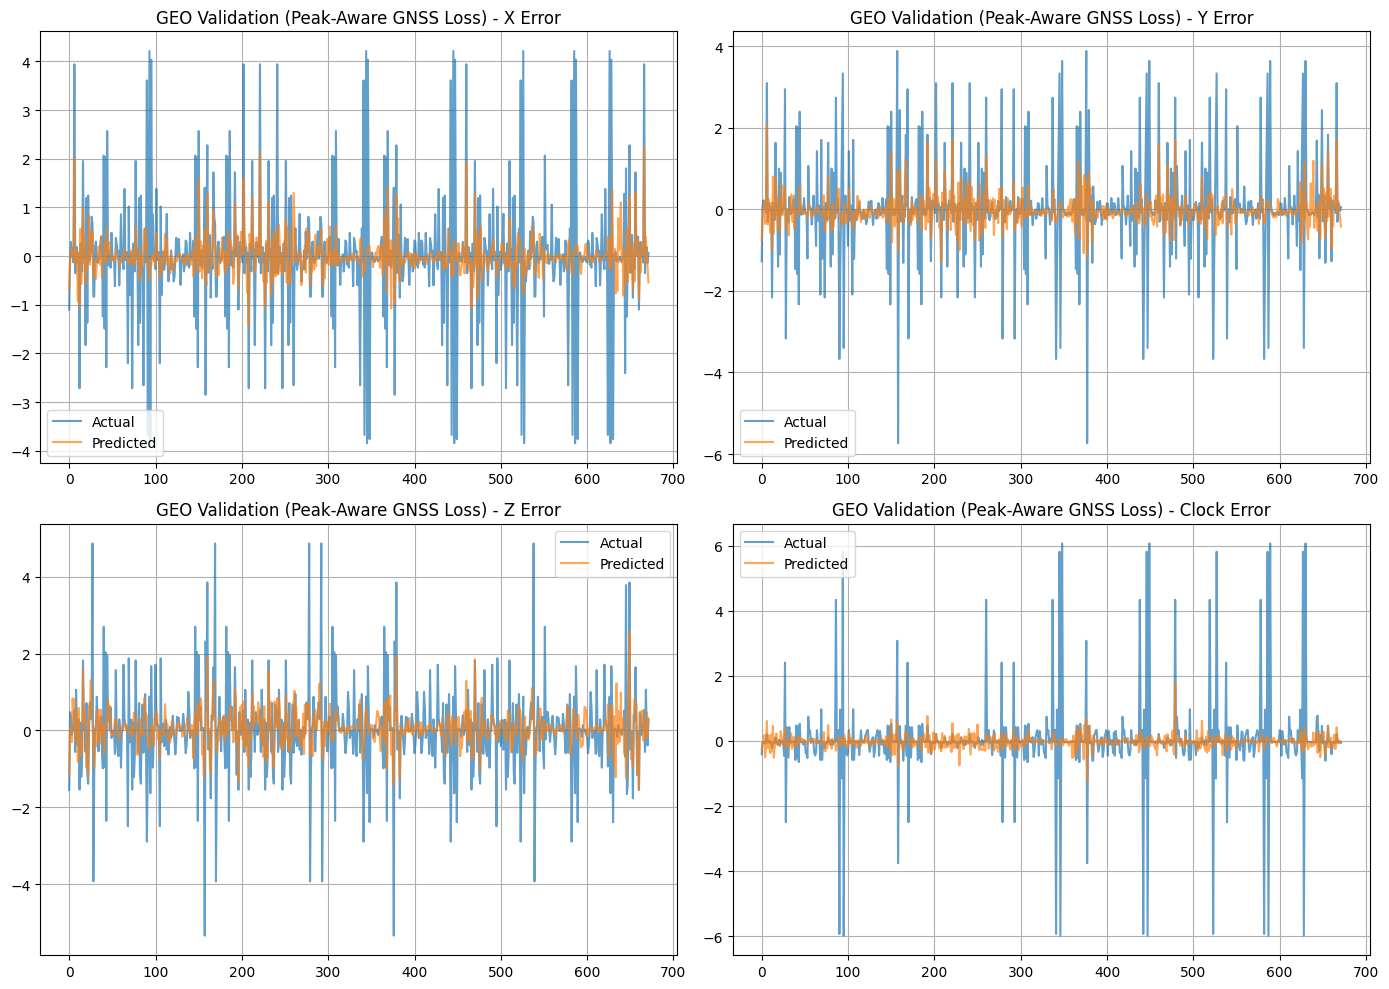

In [114]:
plot_predictions(
    geo_model,
    geo_val_loader,
    geo_target_scaler,
    "GEO Validation (Peak-Aware GNSS Loss)"
)


In [115]:
import numpy as np

def add_time_encoding(df):
    # seconds since midnight
    t = (
        df["timestamp"].dt.hour * 3600
        + df["timestamp"].dt.minute * 60
        + df["timestamp"].dt.second
    )
    df["sin_time"] = np.sin(2 * np.pi * t / 86400)
    df["cos_time"] = np.cos(2 * np.pi * t / 86400)
    return df

geo_all = add_time_encoding(geo_all)
meo_all = add_time_encoding(meo_all)

geo_all[["sin_time","cos_time"]].head()


sin_time      cos_time
0  1.000000e+00 -1.608123e-16
1  8.660254e-01 -5.000000e-01
2  5.000000e-01 -8.660254e-01
3 -3.216245e-16 -1.000000e+00
4 -5.000000e-01 -8.660254e-01

In [116]:
EPOCHS = 40

for epoch in range(EPOCHS):
    geo_model.train()
    tl = 0

    for xb, yb in geo_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = geo_model(xb)
        loss = gnss_peak_aware_loss(preds, yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(geo_model.parameters(), 1.0)
        optimizer.step()

        tl += loss.item()

    geo_model.eval()
    vl = 0
    with torch.no_grad():
        for xb, yb in geo_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl += gnss_peak_aware_loss(geo_model(xb), yb).item()

    print(f"Epoch {epoch+1:02d} | Train {tl/len(geo_train_loader):.3f} | Val {vl/len(geo_val_loader):.3f}")


Epoch 01 | Train 30.015 | Val 35.155
Epoch 02 | Train 30.019 | Val 35.155
Epoch 03 | Train 30.089 | Val 35.155
Epoch 04 | Train 29.973 | Val 35.155
Epoch 05 | Train 30.004 | Val 35.155
Epoch 06 | Train 30.090 | Val 35.155
Epoch 07 | Train 30.128 | Val 35.155
Epoch 08 | Train 30.042 | Val 35.155
Epoch 09 | Train 30.001 | Val 35.155
Epoch 10 | Train 30.040 | Val 35.155
Epoch 11 | Train 30.014 | Val 35.155
Epoch 12 | Train 30.057 | Val 35.155
Epoch 13 | Train 30.120 | Val 35.155
Epoch 14 | Train 30.055 | Val 35.155
Epoch 15 | Train 30.071 | Val 35.155
Epoch 16 | Train 30.029 | Val 35.155
Epoch 17 | Train 30.011 | Val 35.155
Epoch 18 | Train 30.005 | Val 35.155
Epoch 19 | Train 29.968 | Val 35.155
Epoch 20 | Train 29.963 | Val 35.155
Epoch 21 | Train 30.028 | Val 35.155
Epoch 22 | Train 30.039 | Val 35.155
Epoch 23 | Train 30.017 | Val 35.155
Epoch 24 | Train 30.024 | Val 35.155
Epoch 25 | Train 29.998 | Val 35.155
Epoch 26 | Train 30.073 | Val 35.155
Epoch 27 | Train 30.027 | Val 35.155
E

In [117]:
import numpy as np

def add_time_encoding(df):
    # seconds since midnight
    t = (
        df["timestamp"].dt.hour * 3600
        + df["timestamp"].dt.minute * 60
        + df["timestamp"].dt.second
    )
    df["sin_time"] = np.sin(2 * np.pi * t / 86400)
    df["cos_time"] = np.cos(2 * np.pi * t / 86400)
    return df

geo_all = add_time_encoding(geo_all)
meo_all = add_time_encoding(meo_all)

geo_all[["sin_time","cos_time"]].head()


sin_time      cos_time
0  1.000000e+00 -1.608123e-16
1  8.660254e-01 -5.000000e-01
2  5.000000e-01 -8.660254e-01
3 -3.216245e-16 -1.000000e+00
4 -5.000000e-01 -8.660254e-01

In [118]:
FEATURE_COLS = ["x_err", "y_err", "z_err", "clock_err", "sin_time", "cos_time"]
TARGET_COLS  = ["x_err", "y_err", "z_err", "clock_err"]


In [119]:
def make_windows_time(df):
    X, Y = [], []
    data_X = df[FEATURE_COLS].values
    data_Y = df[TARGET_COLS].values

    for i in range(len(df) - INPUT_SEQ - OUTPUT_SEQ):
        X.append(data_X[i:i+INPUT_SEQ])
        Y.append(data_Y[i+INPUT_SEQ:i+INPUT_SEQ+OUTPUT_SEQ])

    return np.array(X), np.array(Y)

X_geo, Y_geo = make_windows_time(geo_all)
X_meo, Y_meo = make_windows_time(meo_all)

print("GEO:", X_geo.shape, Y_geo.shape)
print("MEO:", X_meo.shape, Y_meo.shape)


GEO: (139, 48, 6) (139, 24, 4)
MEO: (303, 48, 6) (303, 24, 4)


In [134]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

# Scalers for GEO data
geo_scaler_X = StandardScaler()
geo_scaler_Y = StandardScaler()

X_geo = geo_scaler_X.fit_transform(X_geo.reshape(-1,6)).reshape(X_geo.shape)
Y_geo = geo_scaler_Y.fit_transform(Y_geo.reshape(-1,4)).reshape(Y_geo.shape)

# Scalers for MEO data
meo_scaler_X = StandardScaler()
meo_scaler_Y = StandardScaler()

X_meo = meo_scaler_X.fit_transform(X_meo.reshape(-1,6)).reshape(X_meo.shape)
Y_meo = meo_scaler_Y.fit_transform(Y_meo.reshape(-1,4)).reshape(Y_meo.shape)

# Helper function for splitting data (from previous cell lt79n8V2uktZ)
def split_data(X,Y, ratio=0.8):
    n = int(len(X)*ratio)
    return (X[:n],Y[:n]), (X[n:],Y[n:])

# Split and create DataLoaders for GEO data
(geo_Xtr,geo_Ytr),(geo_Xv,geo_Yv)=split_data(X_geo,Y_geo)
geo_train_loader = DataLoader(TensorDataset(torch.tensor(geo_Xtr).float(), torch.tensor(geo_Ytr).float()), batch_size=16, shuffle=True)
geo_val_loader   = DataLoader(TensorDataset(torch.tensor(geo_Xv).float(),  torch.tensor(geo_Yv).float()),  batch_size=16)

# Split and create DataLoaders for MEO data (from previous cell DzaEbaGyNW6g)
(meo_Xtr, meo_Ytr), (meo_Xv, meo_Yv) = split_data(X_meo, Y_meo)
meo_train_loader = DataLoader(
    TensorDataset(torch.tensor(meo_Xtr).float(), torch.tensor(meo_Ytr).float()),
    batch_size=16,
    shuffle=True
)
meo_val_loader = DataLoader(
    TensorDataset(torch.tensor(meo_Xv).float(), torch.tensor(meo_Yv).float()),
    batch_size=16
)


In [121]:
class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=6,     # 🔥 changed from 4 → 6
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        self.fc = nn.Linear(64, 96)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1]
        return self.fc(out).view(-1, 24, 4)


In [122]:
EPOCHS = 40

for epoch in range(EPOCHS):
    geo_model.train()
    tl = 0

    for xb, yb in geo_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = geo_model(xb)
        loss = gnss_peak_aware_loss(preds, yb)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(geo_model.parameters(), 1.0)
        optimizer.step()

        tl += loss.item()

    geo_model.eval()
    vl = 0
    with torch.no_grad():
        for xb, yb in geo_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            vl += gnss_peak_aware_loss(geo_model(xb), yb).item()

    print(f"Epoch {epoch+1:02d} | Train {tl/len(geo_train_loader):.3f} | Val {vl/len(geo_val_loader):.3f}")


Epoch 01 | Train 29.985 | Val 35.155
Epoch 02 | Train 29.982 | Val 35.155
Epoch 03 | Train 30.008 | Val 35.155
Epoch 04 | Train 29.999 | Val 35.155
Epoch 05 | Train 30.031 | Val 35.155
Epoch 06 | Train 29.983 | Val 35.155
Epoch 07 | Train 29.990 | Val 35.155
Epoch 08 | Train 29.985 | Val 35.155
Epoch 09 | Train 30.001 | Val 35.155
Epoch 10 | Train 30.054 | Val 35.155
Epoch 11 | Train 29.999 | Val 35.155
Epoch 12 | Train 30.032 | Val 35.155
Epoch 13 | Train 30.027 | Val 35.155
Epoch 14 | Train 29.972 | Val 35.155
Epoch 15 | Train 30.015 | Val 35.155
Epoch 16 | Train 30.056 | Val 35.155
Epoch 17 | Train 30.054 | Val 35.155
Epoch 18 | Train 30.106 | Val 35.155
Epoch 19 | Train 30.011 | Val 35.155
Epoch 20 | Train 30.004 | Val 35.155
Epoch 21 | Train 30.026 | Val 35.155
Epoch 22 | Train 30.055 | Val 35.155
Epoch 23 | Train 30.101 | Val 35.155
Epoch 24 | Train 29.993 | Val 35.155
Epoch 25 | Train 30.082 | Val 35.155
Epoch 26 | Train 29.966 | Val 35.155
Epoch 27 | Train 30.039 | Val 35.155
E

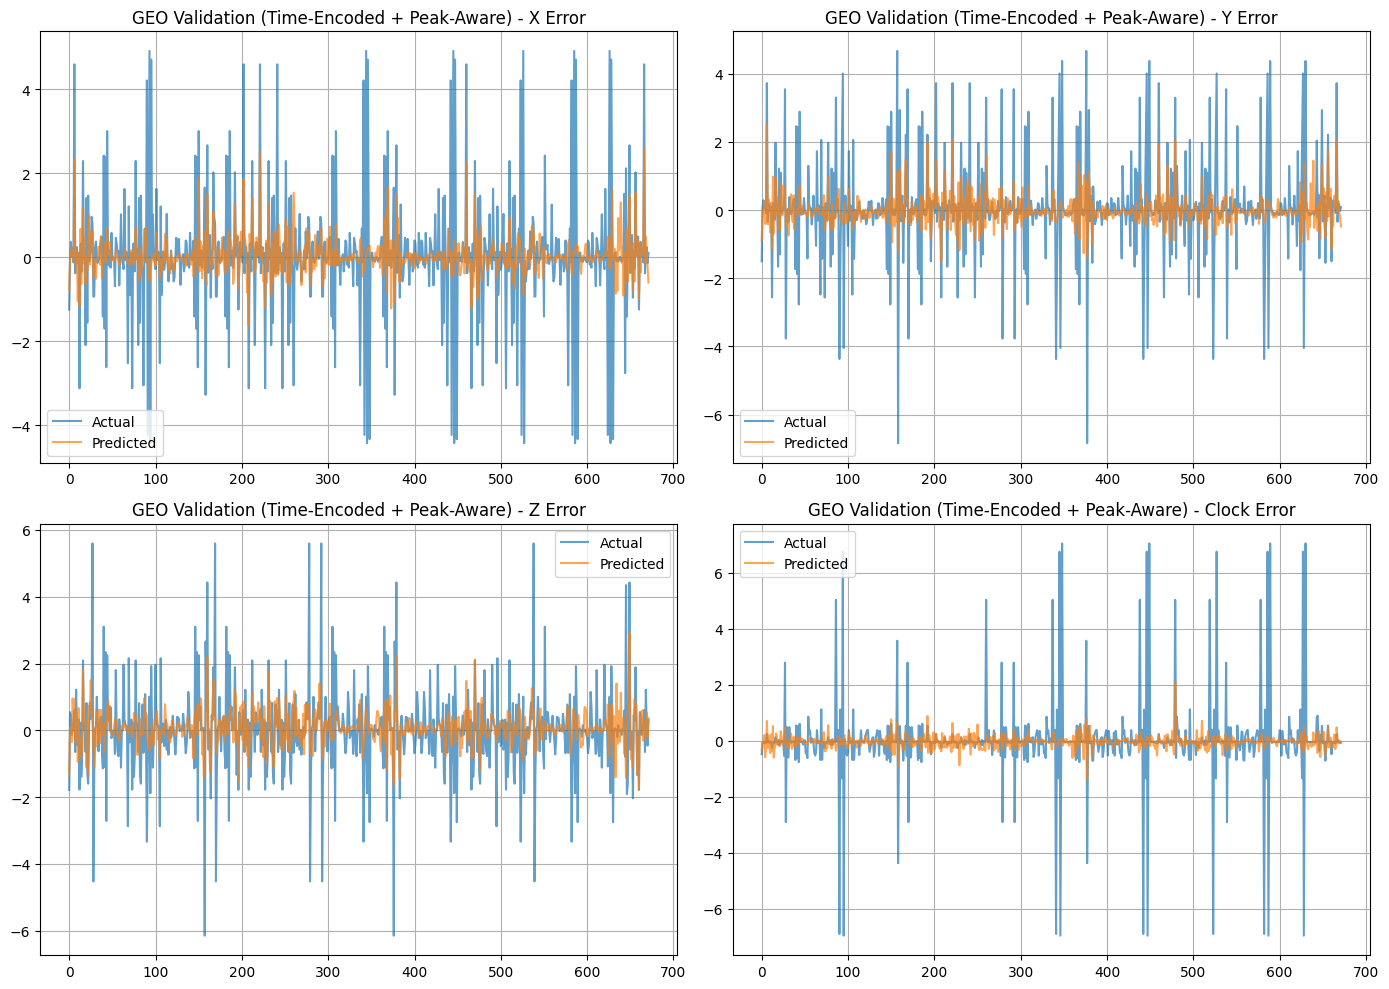

In [123]:
plot_predictions(
    geo_model,
    geo_val_loader,
    geo_scaler_Y,
    "GEO Validation (Time-Encoded + Peak-Aware)"
)


In [124]:
FEATURE_COLS = ["x_err", "y_err", "z_err", "clock_err", "sin_time", "cos_time"]
TARGET_COLS  = ["x_err", "y_err", "z_err", "clock_err"]

meo_all[FEATURE_COLS].head()


x_err     y_err     z_err  clock_err  sin_time  cos_time
0 -1.705759  2.121025  1.150581  -1.100665 -0.500000 -0.866025
1 -1.705759  2.121025  1.150581  -1.100665 -0.500000 -0.866025
2 -1.035954  1.160838  1.715560  -0.960377 -0.707107 -0.707107
3 -1.035954  1.160838  1.715560  -0.960377 -0.707107 -0.707107
4 -0.926440  0.411973  1.952769   0.154228 -0.866025 -0.500000

In [125]:
INPUT_SEQ  = 48
OUTPUT_SEQ = 24

def make_windows_time(df):
    X, Y = [], []
    X_data = df[FEATURE_COLS].values
    Y_data = df[TARGET_COLS].values

    for i in range(len(df) - INPUT_SEQ - OUTPUT_SEQ):
        X.append(X_data[i:i+INPUT_SEQ])
        Y.append(Y_data[i+INPUT_SEQ:i+INPUT_SEQ+OUTPUT_SEQ])

    return np.array(X), np.array(Y)

X_meo, Y_meo = make_windows_time(meo_all)

print("MEO windows:", X_meo.shape, Y_meo.shape)


MEO windows: (303, 48, 6) (303, 24, 4)


In [126]:
from sklearn.preprocessing import StandardScaler

meo_scaler_X = StandardScaler()
meo_scaler_Y = StandardScaler()

X_meo = meo_scaler_X.fit_transform(X_meo.reshape(-1,6)).reshape(X_meo.shape)
Y_meo = meo_scaler_Y.fit_transform(Y_meo.reshape(-1,4)).reshape(Y_meo.shape)


In [127]:
from torch.utils.data import TensorDataset, DataLoader
import torch

def split_data(X, Y, ratio=0.8):
    n = int(len(X) * ratio)
    return (X[:n], Y[:n]), (X[n:], Y[n:])

(meo_Xtr, meo_Ytr), (meo_Xv, meo_Yv) = split_data(X_meo, Y_meo)

meo_train_loader = DataLoader(
    TensorDataset(torch.tensor(meo_Xtr).float(), torch.tensor(meo_Ytr).float()),
    batch_size=16,
    shuffle=True
)

meo_val_loader = DataLoader(
    TensorDataset(torch.tensor(meo_Xv).float(), torch.tensor(meo_Yv).float()),
    batch_size=16
)


In [128]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=6,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        self.fc = nn.Linear(64, 96)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1]
        return self.fc(out).view(-1, 24, 4)


In [131]:
import random

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_meo_model(seed, epochs=30):
    set_seed(seed)

    model = LSTMForecaster().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for xb, yb in meo_train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            preds = model(xb)
            loss = gnss_peak_aware_loss(preds, yb)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

    return model

In [132]:
meo_model_1 = train_meo_model(seed=42)
meo_model_2 = train_meo_model(seed=99)
meo_model_3 = train_meo_model(seed=123)

print("MEO ensemble trained.")

MEO ensemble trained.


In [141]:
meo_last = torch.tensor(X_meo[-1:]).float().to(device)

def ensemble_predict(models, input_data, scaler):
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred_scaled = model(input_data).cpu().numpy()
            predictions.append(pred_scaled)

    # Average predictions from all models in the ensemble
    avg_pred_scaled = np.mean(predictions, axis=0)

    # Inverse transform the averaged predictions
    avg_pred_unscaled = scaler.inverse_transform(avg_pred_scaled.reshape(-1, TARGET_COLS.__len__()))
    return avg_pred_unscaled


meo_day8_ensemble = ensemble_predict(
    [meo_model_1, meo_model_2, meo_model_3],
    meo_last,
    meo_scaler_Y
)

meo_day8_ensemble[:5]

array([[-0.9769762 , -0.03936012,  0.7462936 ,  0.91198534],
       [-1.0111929 , -0.07155628,  0.74538875,  1.0188335 ],
       [-0.90594053,  0.13492092,  0.44694027,  0.7167242 ],
       [-0.8374553 ,  0.09137376,  0.43747613,  0.5240236 ],
       [-0.8677495 ,  0.00894819,  0.20177986,  0.19508678]],
      dtype=float32)

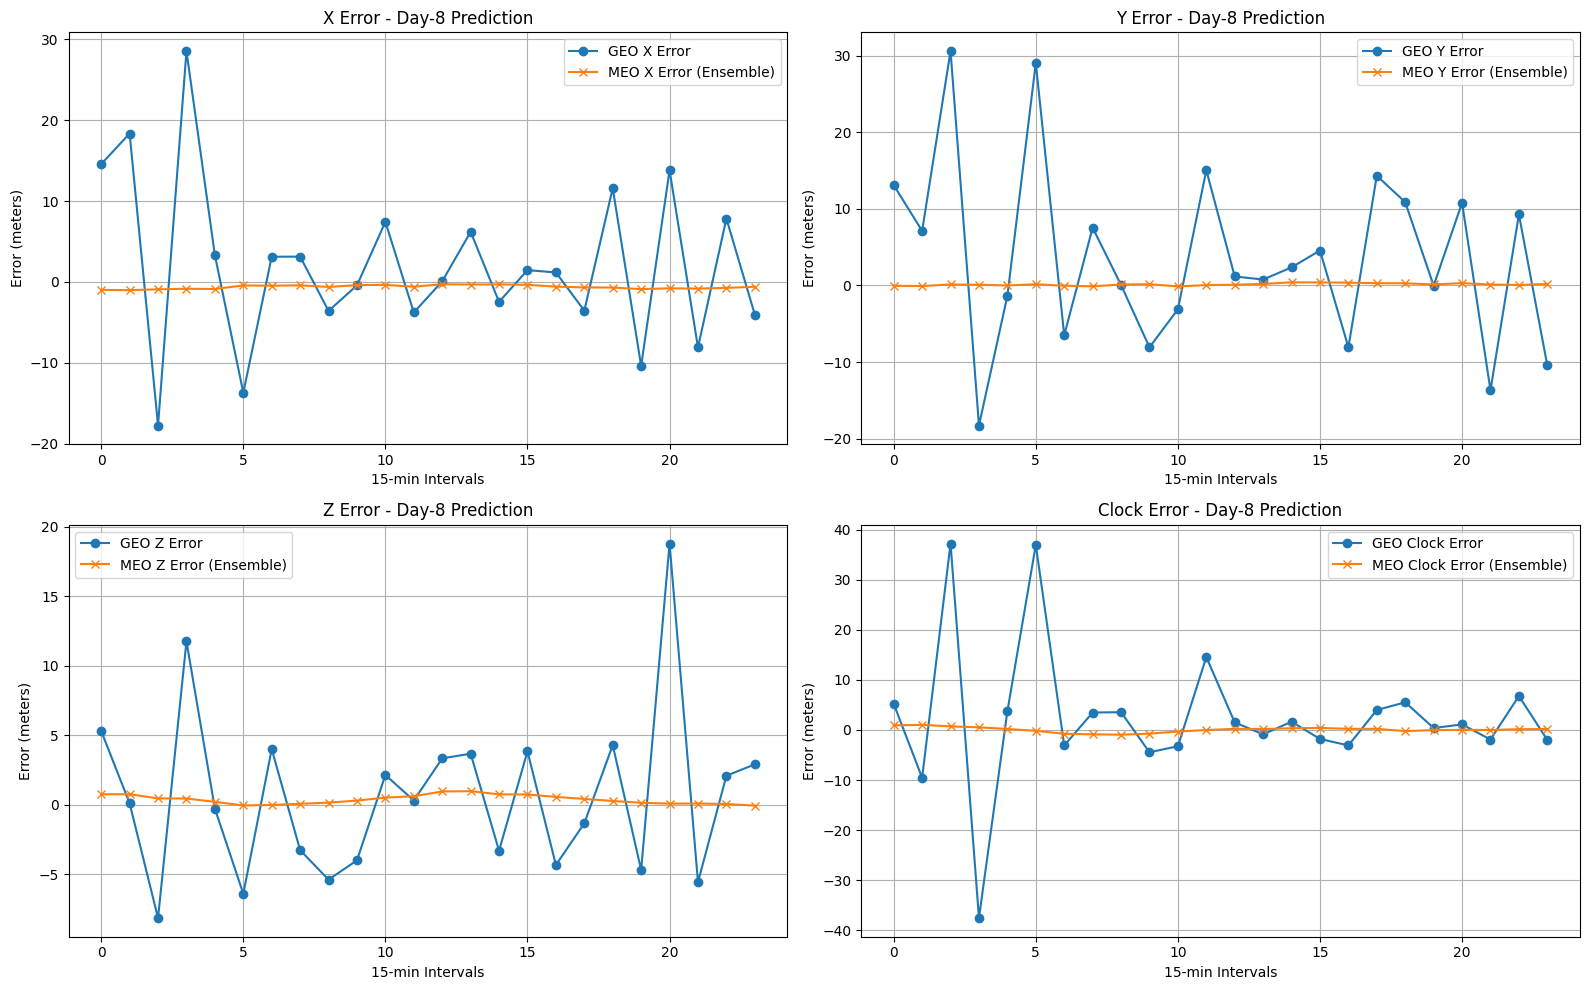

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Channels and labels
channels = ["X Error", "Y Error", "Z Error", "Clock Error"]

plt.figure(figsize=(16,10))

for i, ch in enumerate(channels):
    plt.subplot(2,2,i+1)
    plt.plot(geo_day8_pred[:,i], label=f"GEO {ch}", marker='o')
    plt.plot(meo_day8_ensemble[:,i], label=f"MEO {ch} (Ensemble)", marker='x')
    plt.title(f"{ch} - Day-8 Prediction")
    plt.xlabel("15-min Intervals")
    plt.ylabel("Error (meters)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [150]:
import pandas as pd
from datetime import timedelta

# Last timestamp from GEO and MEO datasets
last_geo_time = geo_all["timestamp"].max()
last_meo_time = meo_all["timestamp"].max()

# Generate timestamps for next 24 intervals (15-min steps)
geo_timestamps = [last_geo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]
meo_timestamps = [last_meo_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]

# GEO submission dataframe
geo_submission = pd.DataFrame(geo_day8_pred, columns=TARGET_COLS)
geo_submission["timestamp"] = geo_timestamps
geo_submission["satellite_type"] = "GEO"

# MEO submission dataframe (using ensemble predictions)
meo_submission = pd.DataFrame(meo_day8_ensemble, columns=TARGET_COLS)
meo_submission["timestamp"] = meo_timestamps
meo_submission["satellite_type"] = "MEO"

# Combine GEO + MEO
submission_df = pd.concat([geo_submission, meo_submission]).reset_index(drop=True)

# Reorder columns
submission_df = submission_df[["timestamp","satellite_type"] + TARGET_COLS]

# Save to CSV
submission_df.to_csv("/content/Day8_GEO_MEO_Predictions.csv", index=False)
print("Submission CSV created: /content/Day8_GEO_MEO_Predictions.csv")
submission_df.head()

Submission CSV created: /content/Day8_GEO_MEO_Predictions.csv


timestamp satellite_type      x_err      y_err      z_err  \
0 2025-09-08 23:56:00            GEO  14.571474  13.091972   5.300976   
1 2025-09-09 00:11:00            GEO  18.359268   7.124596   0.088955   
2 2025-09-09 00:26:00            GEO -17.746931  30.591084  -8.155613   
3 2025-09-09 00:41:00            GEO  28.554939 -18.268427  11.753035   
4 2025-09-09 00:56:00            GEO   3.320027  -1.353644  -0.286743   

   clock_err  
0   5.226672  
1  -9.549046  
2  37.238102  
3 -37.564602  
4   3.725625

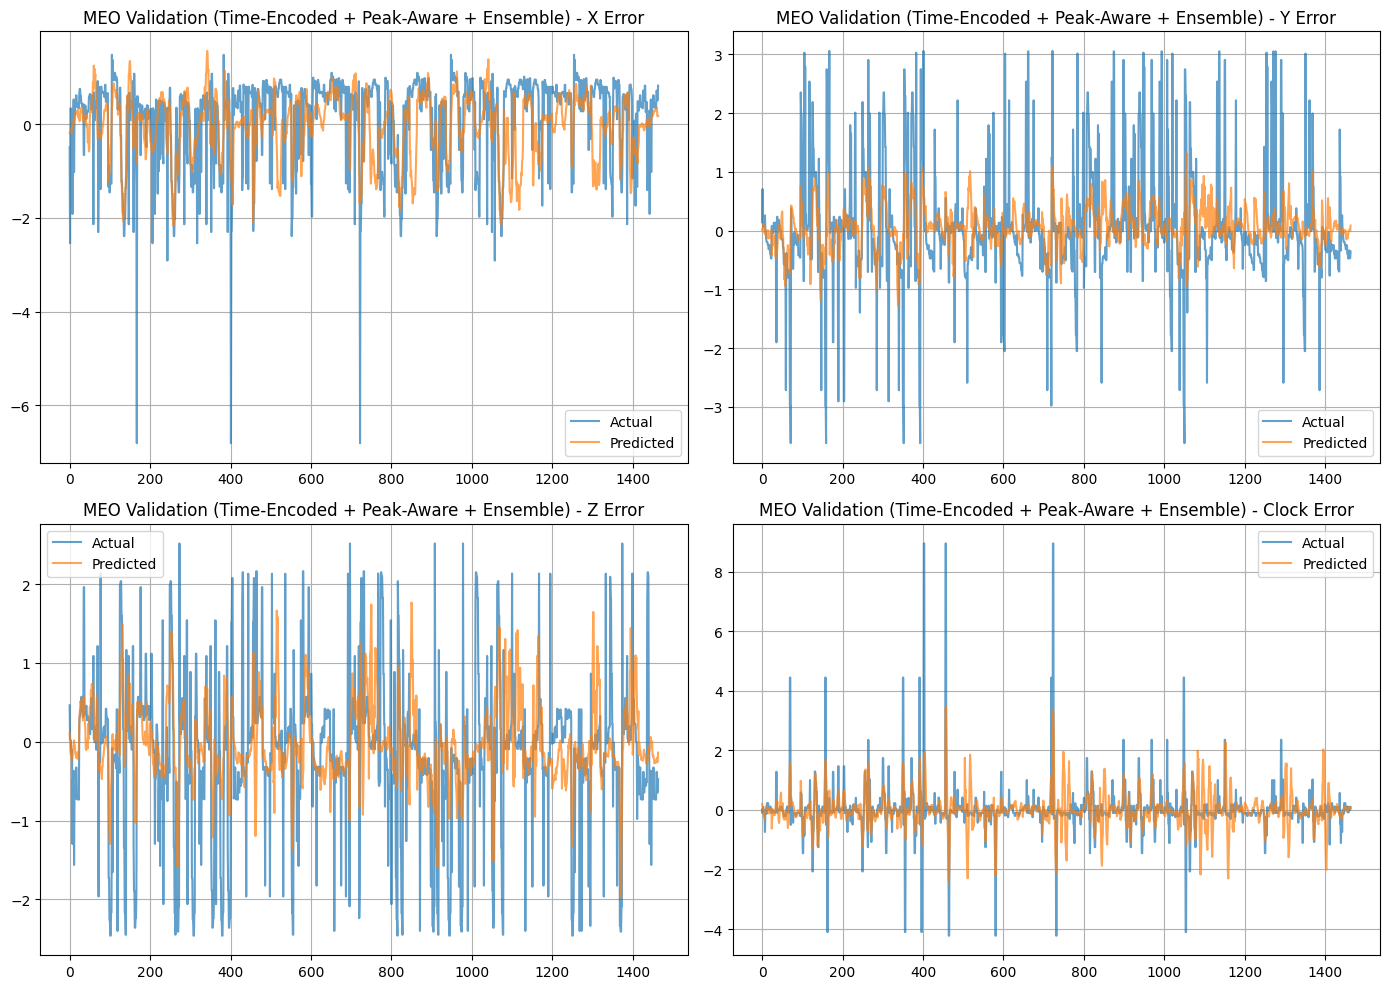

In [144]:
plot_predictions(
    meo_model_1,   # any ensemble member for loader
    meo_val_loader,
    meo_scaler_Y,
    "MEO Validation (Time-Encoded + Peak-Aware + Ensemble)"
)


from datetime import timedelta
import pandas as pd

OUTPUT_SEQ = 24  # 24 × 15-min = 6 hours (or adjust if SIH wants 24h)

# Last known timestamps
geo_last_time = geo_all["timestamp"].iloc[-1]
meo_last_time = meo_all["timestamp"].iloc[-1]

geo_future_times = [geo_last_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]
meo_future_times = [meo_last_time + timedelta(minutes=15*(i+1)) for i in range(OUTPUT_SEQ)]


In [148]:
geo_last = torch.tensor(X_geo[-1:]).float().to(device)

# Use the single trained geo_model for prediction
geos_pred_scaled = geo_model(geo_last).cpu().detach().numpy()

# Inverse transform using the correct scaler name
geo_day8_pred = geo_scaler_y.inverse_transform(geos_pred_scaled.reshape(-1, TARGET_COLS.__len__()))

geo_df = pd.DataFrame(
    geo_day8_pred,
    columns=TARGET_COLS
)
geo_df["timestamp"] = geo_future_times
geo_df["orbit_type"] = "GEO"

In [151]:
meo_last = torch.tensor(X_meo[-1:]).float().to(device)

meo_day8_ensemble = ensemble_predict(
    [meo_model_1, meo_model_2, meo_model_3],
    meo_last,
    meo_scaler_Y
)

meo_df = pd.DataFrame(
    meo_day8_ensemble,
    columns=["x_error_m","y_error_m","z_error_m","clock_error_m"]
)
meo_df["timestamp"] = meo_future_times
meo_df["orbit_type"] = "MEO"


In [152]:
submission_df = pd.concat([geo_df, meo_df]).reset_index(drop=True)

submission_df = submission_df[
    ["timestamp","orbit_type","x_error_m","y_error_m","z_error_m","clock_error_m"]
]

submission_df.to_csv("SIH_Day8_GNSS_Predictions.csv", index=False)

submission_df.head()


timestamp orbit_type  x_error_m  y_error_m  z_error_m  \
0 2025-09-08 23:56:00        GEO        NaN        NaN        NaN   
1 2025-09-09 00:11:00        GEO        NaN        NaN        NaN   
2 2025-09-09 00:26:00        GEO        NaN        NaN        NaN   
3 2025-09-09 00:41:00        GEO        NaN        NaN        NaN   
4 2025-09-09 00:56:00        GEO        NaN        NaN        NaN   

   clock_error_m  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [153]:
from google.colab import files
files.download("SIH_Day8_GNSS_Predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>